In [1]:
import os

os.environ["CHECKPOINTS_PATH"] = "../checkpoints"
os.environ["TRACKING_RESULTS_PATH"] = "data/processed_tracking_results"

import itertools
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from src.api.models.pydantic import SimRoomClassDTO
from src.config import TOBII_GLASSES_FPS, VIEWED_RADIUS
from ultralytics import YOLO
import subprocess

from experiment.settings import (
    CLASS_ID_TO_NAME,
    FULLY_LABELED_RECORDINGS,
    GAZE_SEGMENTATION_RESULTS_PATH,
    RECORDINGS_PATH,
    RECORDING_FRAMES_PATH,
    OBJECT_DETECTION_MODELS_PATH,
    COMPARISON_SETS_PATH,
    NAME_TO_CLASS_ID,
    OBJECT_DETECTION_PREDICTIONS_PATH,
    FINAL_PREDICTION_VIDEOS_PATH,
    IGNORED_CLASS_IDS,
    UNKNOWN_CLASS_ID,
    SIMROOM_ID,
    MISSING_GROUND_TRUTH_CLASS_ID,
    MISSING_PREDICTION_CLASS_ID
)
from src.api.db import Session, engine
from src.api.repositories import simrooms_repo
from src.api.services import simrooms_service, gaze_service
import cv2
import numpy as np
import tempfile
from src.utils import extract_frames_to_dir
import albumentations as A
from tqdm import tqdm
import json
from torchvision.ops import box_iou
import torch
import collections
from src.api.utils import image_utils
from experiment import experiment_utils
from experiment.experiment_utils import CMMetrics
import multiprocessing
import functools
import itertools

IMG_CROP_SIZE = 640
IMG_CROP_SIZE_HALF = IMG_CROP_SIZE // 2

models = list(OBJECT_DETECTION_MODELS_PATH.glob("*.pt"))

/home/zilian/projects/bachelorproef/.venv/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Object Detection Inference

## Inference - Create Comparison Sets

In [2]:
def get_frame_to_gaze_segmentation_data(
    gaze_segmentation_results_path: Path,
):
    if not gaze_segmentation_results_path.exists():
        raise ValueError(
            f"Gaze segmentation results path {gaze_segmentation_results_path} does not exist. Please run the gaze segmentation pipeline first."
        )

    frame_to_gaze_segmentation_data = {}
    for result in gaze_segmentation_results_path.glob("*.npz"):
        file = np.load(result)
        frame_idx = file["frame_idx"]
        frame_to_gaze_segmentation_data[int(frame_idx)] = {
            "boxes": file["boxes"],
            "object_ids": file["object_ids"].tolist(),
        }

    return frame_to_gaze_segmentation_data

def create_frame_crop(
    image: np.ndarray,
    gaze_position: tuple[int, int],
    frame_to_gaze_segmentation_data: dict[int, dict],
    frame_idx: int
) -> tuple[np.ndarray, list[tuple[int, int, int, int]], list[int]]:
    gaze_segmentation_boxes = frame_to_gaze_segmentation_data[frame_idx]["boxes"]
    gaze_segmentation_object_ids = frame_to_gaze_segmentation_data[frame_idx][
        "object_ids"
    ]

    # Create a crop around the gaze position
    cx, cy = gaze_position
    x_min = max(0, cx - IMG_CROP_SIZE_HALF)
    y_min = max(0, cy - IMG_CROP_SIZE_HALF)
    x_max = min(image.shape[1], cx + IMG_CROP_SIZE_HALF)
    y_max = min(image.shape[0], cy + IMG_CROP_SIZE_HALF)

    transform = A.Compose(
        [
            A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max),
            A.PadIfNeeded(min_height=IMG_CROP_SIZE, min_width=IMG_CROP_SIZE),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc", label_fields=["object_ids"], min_visibility=0.7
        ),
    )

    transformed = transform(
        image=image,
        bboxes=gaze_segmentation_boxes,
        object_ids=gaze_segmentation_object_ids,
    )
    transformed_image = transformed["image"]
    transformed_gs_boxes = transformed["bboxes"]
    transformed_gs_object_ids = transformed["object_ids"]

    return transformed_image, transformed_gs_boxes, transformed_gs_object_ids

def get_comparison_dataset(
    recording_id: str,
    model: YOLO,
    frame_paths: list[Path],
    frame_to_gaze_position: dict[int, tuple[int, int]],
    frame_to_gaze_segmentation_data: dict[int, dict],
) -> None:
    comparison_set_per_frame = {}
    
    for frame_path in tqdm(frame_paths, desc=f"Running inference for {recording_id}"):
        frame_idx = int(frame_path.stem)
        if frame_to_gaze_segmentation_data.get(frame_idx) is None:
            continue

        image = cv2.imread(str(frame_path))
        gaze_position = frame_to_gaze_position[frame_idx]

        transformed_image, transformed_gs_boxes, transformed_gs_object_ids = create_frame_crop(
            image,
            gaze_position,
            frame_to_gaze_segmentation_data,
            frame_idx
        )

        results = model.predict(
            source=transformed_image, conf=0.5, iou=0.5, device="cuda", verbose=False
        )

        predicted_confidences = []
        predicted_bboxes = []
        predicted_class_ids = []
        for box in results[0].boxes:
            conf = float(box.conf[0].cpu().numpy())
            class_id = int(box.cls[0])
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            predicted_confidences.append(conf)
            predicted_bboxes.append((int(x1), int(y1), int(x2), int(y2)))
            predicted_class_ids.append(class_id)

        comparison_set_per_frame[frame_idx] = {
            "gaze_segmentation": {
                "boxes": transformed_gs_boxes.astype(np.int32).tolist(),
                "object_ids": transformed_gs_object_ids,
            },
            "predicted": {
                "boxes": predicted_bboxes,
                "class_ids": predicted_class_ids,
                "confidences": predicted_confidences,
            },
        }

    return comparison_set_per_frame

In [3]:
for model in models:
    model_name = model.stem
    model_comparison_sets_path = COMPARISON_SETS_PATH / model_name

    if model_comparison_sets_path.exists():
        shutil.rmtree(model_comparison_sets_path)
    model_comparison_sets_path.mkdir(parents=True, exist_ok=True)

    print(
        f"Running inference for model {model_name} on {len(FULLY_LABELED_RECORDINGS)} fully labeled recordings"
    )
    for recording_id in FULLY_LABELED_RECORDINGS:
        comparison_set_path = model_comparison_sets_path / f"{recording_id}.json"

        # Get gaze segmentation data for the recording
        gaze_segmentation_results_path = GAZE_SEGMENTATION_RESULTS_PATH / recording_id
        frame_to_gaze_segmentation_data = get_frame_to_gaze_segmentation_data(
            gaze_segmentation_results_path
        )

        # Get frames for the recording
        recording_frames_path = RECORDING_FRAMES_PATH / recording_id
        frames = list(recording_frames_path.glob("*.jpg"))

        # Get gaze positions for the recording
        frame_to_gaze_position = gaze_service.get_gaze_position_per_frame(
            recording_id, len(frames)
        )

        comparison_set_per_frame = get_comparison_dataset(
            recording_id=recording_id, 
            model=YOLO(model), 
            frame_paths=frames,
            frame_to_gaze_position=frame_to_gaze_position,
            frame_to_gaze_segmentation_data=frame_to_gaze_segmentation_data
        )

        with open(comparison_set_path, "w") as f:
            f.write(json.dumps(comparison_set_per_frame, indent=4))

Running inference for model same_background_640_3000 on 10 fully labeled recordings


Running inference for 67b71a70-da64-467a-9fb6-91bc29265fd1: 100%|██████████| 2064/2064 [00:24<00:00, 84.63it/s] 


Running inference for 32f02db7-adc0-4556-a2da-ed2ba60a58c9: 100%|██████████| 1365/1365 [00:18<00:00, 74.62it/s]


Running inference for b8eeecc0-06b1-47f7-acb5-89aab3c1724d: 100%|██████████| 1557/1557 [00:17<00:00, 91.38it/s] 


Running inference for d50c5f3b-2822-4462-9880-5a8f0dd46bfb: 100%|██████████| 1500/1500 [00:16<00:00, 92.78it/s] 
Running inference for 9fa3e3b8-ed94-4b06-ba49-e66e3997d710: 100%|██████████| 1229/1229 [00:13<00:00, 89.99it/s] 
Running inference for 98128cdc-ffeb-40cb-9528-573e25028e87: 100%|██████████| 1543/1543 [00:19<00:00, 81.01it/s] 
Running inference for 89b60530-e0e4-4f5d-9ee6-af85c8d99ff4: 100%|██████████| 1270/1270 [00:15<00:00, 80.13it/s]


Running inference for 2fe01600-c057-40ee-8434-4e9e0688ca2d: 100%|██████████| 2041/2041 [00:27<00:00, 73.97it/s]


Running inference for 67823ccd-a1f0-4cde-b954-3b9e5fe160c1: 100%|██████████| 1554/1554 [00:20<00:00, 77.51it/s] 
Running inference for b8f453aa-5a12-4cbb-a0ec-20eb503f8797: 100%|██████████| 1364/1364 [00:18<00:00, 72.56it/s]


Running inference for model same_background_640_500 on 10 fully labeled recordings


Running inference for 67b71a70-da64-467a-9fb6-91bc29265fd1: 100%|██████████| 2064/2064 [00:21<00:00, 95.22it/s] 


Running inference for 32f02db7-adc0-4556-a2da-ed2ba60a58c9: 100%|██████████| 1365/1365 [00:16<00:00, 84.87it/s] 


Running inference for b8eeecc0-06b1-47f7-acb5-89aab3c1724d: 100%|██████████| 1557/1557 [00:15<00:00, 103.20it/s]


Running inference for d50c5f3b-2822-4462-9880-5a8f0dd46bfb: 100%|██████████| 1500/1500 [00:16<00:00, 93.26it/s] 
Running inference for 9fa3e3b8-ed94-4b06-ba49-e66e3997d710: 100%|██████████| 1229/1229 [00:12<00:00, 95.14it/s] 
Running inference for 98128cdc-ffeb-40cb-9528-573e25028e87: 100%|██████████| 1543/1543 [00:18<00:00, 85.43it/s] 
Running inference for 89b60530-e0e4-4f5d-9ee6-af85c8d99ff4: 100%|██████████| 1270/1270 [00:15<00:00, 80.27it/s]


Running inference for 2fe01600-c057-40ee-8434-4e9e0688ca2d: 100%|██████████| 2041/2041 [00:25<00:00, 78.89it/s]


Running inference for 67823ccd-a1f0-4cde-b954-3b9e5fe160c1: 100%|██████████| 1554/1554 [00:18<00:00, 83.62it/s] 
Running inference for b8f453aa-5a12-4cbb-a0ec-20eb503f8797: 100%|██████████| 1364/1364 [00:19<00:00, 71.46it/s]


Running inference for model same_background_640_1000 on 10 fully labeled recordings


Running inference for 67b71a70-da64-467a-9fb6-91bc29265fd1: 100%|██████████| 2064/2064 [00:21<00:00, 96.39it/s] 


Running inference for 32f02db7-adc0-4556-a2da-ed2ba60a58c9: 100%|██████████| 1365/1365 [00:16<00:00, 84.19it/s] 


Running inference for b8eeecc0-06b1-47f7-acb5-89aab3c1724d: 100%|██████████| 1557/1557 [00:17<00:00, 91.34it/s] 


Running inference for d50c5f3b-2822-4462-9880-5a8f0dd46bfb: 100%|██████████| 1500/1500 [00:16<00:00, 91.31it/s] 
Running inference for 9fa3e3b8-ed94-4b06-ba49-e66e3997d710: 100%|██████████| 1229/1229 [00:13<00:00, 90.52it/s]
Running inference for 98128cdc-ffeb-40cb-9528-573e25028e87: 100%|██████████| 1543/1543 [00:17<00:00, 85.74it/s] 
Running inference for 89b60530-e0e4-4f5d-9ee6-af85c8d99ff4: 100%|██████████| 1270/1270 [00:16<00:00, 77.12it/s]


Running inference for 2fe01600-c057-40ee-8434-4e9e0688ca2d: 100%|██████████| 2041/2041 [00:25<00:00, 78.74it/s] 


Running inference for 67823ccd-a1f0-4cde-b954-3b9e5fe160c1: 100%|██████████| 1554/1554 [00:19<00:00, 78.91it/s] 
Running inference for b8f453aa-5a12-4cbb-a0ec-20eb503f8797: 100%|██████████| 1364/1364 [00:19<00:00, 71.31it/s]


Running inference for model same_background_640_2000 on 10 fully labeled recordings


Running inference for 67b71a70-da64-467a-9fb6-91bc29265fd1: 100%|██████████| 2064/2064 [00:21<00:00, 96.73it/s] 


Running inference for 32f02db7-adc0-4556-a2da-ed2ba60a58c9: 100%|██████████| 1365/1365 [00:16<00:00, 81.91it/s] 


Running inference for b8eeecc0-06b1-47f7-acb5-89aab3c1724d: 100%|██████████| 1557/1557 [00:14<00:00, 109.85it/s]


Running inference for d50c5f3b-2822-4462-9880-5a8f0dd46bfb: 100%|██████████| 1500/1500 [00:16<00:00, 91.93it/s] 
Running inference for 9fa3e3b8-ed94-4b06-ba49-e66e3997d710: 100%|██████████| 1229/1229 [00:12<00:00, 96.31it/s] 
Running inference for 98128cdc-ffeb-40cb-9528-573e25028e87: 100%|██████████| 1543/1543 [00:18<00:00, 84.74it/s] 
Running inference for 89b60530-e0e4-4f5d-9ee6-af85c8d99ff4: 100%|██████████| 1270/1270 [00:14<00:00, 84.98it/s]


Running inference for 2fe01600-c057-40ee-8434-4e9e0688ca2d: 100%|██████████| 2041/2041 [00:26<00:00, 77.94it/s] 


Running inference for 67823ccd-a1f0-4cde-b954-3b9e5fe160c1: 100%|██████████| 1554/1554 [00:19<00:00, 81.55it/s] 
Running inference for b8f453aa-5a12-4cbb-a0ec-20eb503f8797: 100%|██████████| 1364/1364 [00:17<00:00, 78.38it/s]


### Validate Comparison Sets

In [ ]:
def uncrop_box(
    box,
    gaze_position: tuple[int, int],
    image_width: int,
    image_height: int,
) -> tuple[int, int, int, int]:
    IMG_CROP_SIZE = 640
    IMG_CROP_SIZE_HALF = IMG_CROP_SIZE // 2

    cx, cy = gaze_position
    x_min = max(0, cx - IMG_CROP_SIZE_HALF)
    y_min = max(0, cy - IMG_CROP_SIZE_HALF)

    x1, y1, x2, y2 = box
    x1 = int(x1 + x_min)
    y1 = int(y1 + y_min)
    x2 = int(x2 + x_min)
    y2 = int(y2 + y_min)

    return (x1, y1, x2, y2)


def create_comparison_set_validation_video(
    class_names: dict[int, str],
    comparison_set: dict,
    recording_id: str,
    video_result_path: Path,
):
    print("Extracting frames")
    frames, tmp_frames_dir = simrooms_service.extract_tmp_frames(recording_id)
    tmp_frames_path = Path(tmp_frames_dir.name)

    frame_to_gaze_position = gaze_service.get_gaze_position_per_frame(
        recording_id, frame_count=len(frames)
    )

    print("Drawing frames")
    for frame_path in tqdm(frames):
        frame_idx = int(frame_path.stem)

        if comparison_set.get(str(frame_idx)) is None:
            continue

        gx, gy = frame_to_gaze_position[frame_idx]

        frame_comparison_set = comparison_set[str(frame_idx)]
        image = cv2.imread(str(frame_path))

        gs_boxes = frame_comparison_set["gaze_segmentation"]["boxes"]
        gs_object_ids = frame_comparison_set["gaze_segmentation"]["object_ids"]

        predicted_boxes = frame_comparison_set["predicted"]["boxes"]
        predicted_class_ids = frame_comparison_set["predicted"]["class_ids"]
        predicted_confidences = frame_comparison_set["predicted"]["confidences"]

        gs_metadata = zip(gs_boxes, gs_object_ids)
        pred_metadata = zip(predicted_boxes, predicted_class_ids, predicted_confidences)

        for box, object_id in gs_metadata:
            box = uncrop_box(
                box=box,
                gaze_position=(gx, gy),
                image_width=image.shape[1],
                image_height=image.shape[0],
            )
            image = image_utils.draw_labeled_box(
                img=image,
                box=box,
                label=f"GS: {object_id}",
                color="#FF0000",
            )

        for box, class_id, confidence in pred_metadata:
            box = uncrop_box(
                box=box,
                gaze_position=(gx, gy),
                image_width=image.shape[1],
                image_height=image.shape[0],
            )
            image = image_utils.draw_labeled_box(
                img=image,
                box=box,
                label=f"{class_names[class_id]} {confidence:.2f}",
                color="#00FF00",
            )

        # Draw gaze position
        image = cv2.circle(image, (gx, gy), VIEWED_RADIUS, (0, 0, 255), -1)

        # Draw frame index in top left corner of the video
        cv2.putText(
            image,
            f"Frame: {frame_idx}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (255, 255, 255),
            2,
        )

        # in the bottom left, draw a list of all object ids that were detected in the frame
        object_ids = set(gs_object_ids + predicted_class_ids)
        object_ids_text = "Objects: " + ", ".join([
            f"{object_id}"
            for object_id in object_ids
            if object_id not in IGNORED_CLASS_IDS
        ])
        cv2.putText(
            image,
            object_ids_text,
            (10, image.shape[0] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            1,
        )

        # in the bottom right, above the object ids, draw the class ids in this frame (NOT OBJECT IDS)
        class_ids_text = "Class IDs: " + ", ".join([
            f"{class_id}"
            for class_id in set(predicted_class_ids)
            if class_id not in IGNORED_CLASS_IDS
        ])
        cv2.putText(
            image,
            class_ids_text,
            (image.shape[1] - 200, image.shape[0] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            1,
        )

        # save image
        cv2.imwrite(frame_path, image)

    print(f"Creating video for {recording_id}")
    cmd = f'ffmpeg -hwaccel cuda -y -pattern_type glob -framerate {TOBII_GLASSES_FPS} -i "{str(tmp_frames_path)!s}/*.jpg" -c:v libx264 -pix_fmt yuv420p "{str(video_result_path)}"'
    subprocess.run(cmd, shell=True)


COMPARISON_SET_VALIDATION_VIDEOS_PATH = Path("data/comparison_set_validation_videos")
if COMPARISON_SET_VALIDATION_VIDEOS_PATH.exists():
    shutil.rmtree(COMPARISON_SET_VALIDATION_VIDEOS_PATH)
COMPARISON_SET_VALIDATION_VIDEOS_PATH.mkdir(parents=True, exist_ok=True)

for model in models:
    model_name = model.stem
    yolo_model = YOLO(model)
    names = yolo_model.names

    video_results_path = COMPARISON_SET_VALIDATION_VIDEOS_PATH / model_name
    if not video_results_path.exists():
        video_results_path.mkdir(parents=True, exist_ok=True)

    comparison_sets = (COMPARISON_SETS_PATH / model_name).iterdir()
    for comparison_set_path in comparison_sets:
        recording_id = comparison_set_path.stem
        if recording_id != "89b60530-e0e4-4f5d-9ee6-af85c8d99ff4":
            continue

        comparison_set = json.loads(comparison_set_path.read_text())

        create_comparison_set_validation_video(
            names,
            comparison_set=comparison_set,
            recording_id=comparison_set_path.stem,
            video_result_path=video_results_path / f"{comparison_set_path.stem}.mp4",
        )

Extracting frames
Drawing frames


  2%|▏         | 22/1270 [00:00<00:07, 163.84it/s]


KeyboardInterrupt: 

## Inference - Intersect Comparison Sets

In [3]:
def get_thresholded_predictions(
    pred_data: dict,
    min_pred_conf: float
):
    pred_boxes = pred_data["boxes"]
    pred_confs = pred_data["confidences"]
    pred_class_ids = pred_data["class_ids"]

    # Filter out low confidence predictions
    thresholded_predictions = [
        (box, conf, class_id)
        for box, conf, class_id in zip(pred_boxes, pred_confs, pred_class_ids)
        if conf >= min_pred_conf
    ]
    return thresholded_predictions

def remove_duplicate_predictions(
    thresholded_predictions: list[tuple],
):
    best_per_class = {}  # {class_id: (box, conf, class_id)}
    for box, conf, class_id in thresholded_predictions:
        if class_id not in best_per_class or conf > best_per_class[class_id][1]:
            best_per_class[class_id] = (box, conf, class_id)
    return list(best_per_class.values())
    
def get_matched_boxes_per_frame(
    comparison_set: dict,
    min_pred_conf: float,
    iou_threshold: float,
):
    matched_boxes_per_frame = {}

    for frame_idx, frame_data in comparison_set.items():
        pred_data = frame_data["predicted"]
        gs_boxes = frame_data["gaze_segmentation"]["boxes"]
        gs_object_ids = frame_data["gaze_segmentation"]["object_ids"]

        thresholded_predictions = get_thresholded_predictions(
            pred_data=pred_data,
            min_pred_conf=min_pred_conf,
        )
        if len(thresholded_predictions) == 0:
            # No predictions above the confidence threshold
            continue

        predictions = remove_duplicate_predictions(
            thresholded_predictions=thresholded_predictions,
        )
        pred_boxes, pred_confs, pred_class_ids = zip(*predictions)

        # For each GS box, find its best OD match above threshold
        potential_matches = []  # Stores (iou_score, gs_idx, pred_idx)
        for i, gs_box in enumerate(gs_boxes):
            best_iou_for_gs_box = -1.0
            best_pred_idx_for_gs_box = -1

            for j, pred_box in enumerate(pred_boxes):
                iou = float(box_iou(torch.tensor([gs_box]), torch.tensor([pred_box])))

                if iou > best_iou_for_gs_box:
                    best_iou_for_gs_box = iou
                    best_pred_idx_for_gs_box = j

            if best_iou_for_gs_box >= iou_threshold:  # Use >= to include threshold itself
                potential_matches.append((
                    best_iou_for_gs_box,
                    i,
                    best_pred_idx_for_gs_box,
                ))

        # Sort potential matches by IoU score in descending order
        potential_matches.sort(key=lambda x: x[0], reverse=True)

        # Initialize lists for the matched pairs for this frame
        matched_gs_info = {"boxes": [], "object_ids": []}
        matched_pred_info = {"boxes": [], "class_ids": [], "confidences": []}
        matched_ious = []

        used_gs_indices = set()
        used_pred_indices = set()

        # Greedy selection of one-to-one matches
        for iou, gs_idx, pred_idx in potential_matches:
            if gs_idx not in used_gs_indices and pred_idx not in used_pred_indices:
                # This is a valid one-to-one match
                matched_gs_info["boxes"].append(gs_boxes[gs_idx])
                matched_gs_info["object_ids"].append(gs_object_ids[gs_idx])

                matched_pred_info["boxes"].append(pred_boxes[pred_idx])
                matched_pred_info["class_ids"].append(pred_class_ids[pred_idx])
                matched_pred_info["confidences"].append(pred_confs[pred_idx])

                matched_ious.append(iou)

                used_gs_indices.add(gs_idx)
                used_pred_indices.add(pred_idx)

        # Store results for the frame, but only if there are matches
        if len(matched_gs_info["boxes"]) > 0:
            matched_boxes_per_frame[frame_idx] = {
                "gaze_segmentation_matched": matched_gs_info,
                "predicted_matched": matched_pred_info,
                "ious": matched_ious,
            }

    return matched_boxes_per_frame


def get_predictions_per_object_id(
    matched_boxes_per_frame: dict,
):
    predictions_per_object_id = {}
    for frame_data in matched_boxes_per_frame.values():
        gs_matched = frame_data["gaze_segmentation_matched"]
        pred_matched = frame_data["predicted_matched"]

        for i, object_id in enumerate(gs_matched["object_ids"]):
            if object_id not in predictions_per_object_id:
                predictions_per_object_id[object_id] = []

            class_id = pred_matched["class_ids"][i]
            conf = pred_matched["confidences"][i]

            predictions_per_object_id[object_id].append({
                "class_id": class_id,
                "confidence": conf,
            })

    return predictions_per_object_id


def filter_by_min_observed_frames(
    predictions_per_object_id: dict,
    min_observed_frames: int,
):
    filtered_predictions = {}
    for object_id, preds_list in predictions_per_object_id.items():
        if len(preds_list) >= min_observed_frames:
            filtered_predictions[object_id] = preds_list
    return filtered_predictions


def get_final_prediction_per_object_id(
    predictions_per_object_id: dict,
):
    best_prediction_per_class = {}
    for object_id, preds_list in predictions_per_object_id.items():
        if not preds_list:
            raise ValueError(
                f"Predictions list for object ID {object_id} is empty. This should not happen."
            )

        class_confidence_sums = collections.defaultdict(float)
        for pred_info in preds_list:
            class_id = pred_info["class_id"]
            confidence = pred_info["confidence"]
            class_confidence_sums[class_id] += confidence

        # Find the class_id with the highest summed confidence
        # .items() gives (key, value) pairs. We want to find the max by value.
        # If there's a tie, max() will return one of them (typically the first one
        # encountered that achieves the maximum value, or based on key order if values are equal).
        winning_class_id = max(class_confidence_sums, key=class_confidence_sums.get)
        max_summed_confidence = class_confidence_sums[winning_class_id]

        prev_best = best_prediction_per_class.get(winning_class_id, None)
        if prev_best is None or prev_best["confidence"] < max_summed_confidence:
            best_prediction_per_class[winning_class_id] = {
                "object_id": object_id,
                "confidence": max_summed_confidence,
            }

    predictions_per_object_id = {}
    for class_id, pred_info in best_prediction_per_class.items():
        object_id = pred_info["object_id"]
        predictions_per_object_id[object_id] = {
            "class_id": class_id,
            "confidence": pred_info["confidence"],
        }

    return predictions_per_object_id

def get_predictions_df(
    model_class_names: dict[int, str],
    comparison_set_path: Path,
    min_pred_conf: float,
    iou_threshold: float,
    min_observed_frames: int,
):
    comparison_set = json.loads(comparison_set_path.read_text())

    matched_boxes_per_frame = get_matched_boxes_per_frame(
        comparison_set=comparison_set,
        min_pred_conf=min_pred_conf,
        iou_threshold=iou_threshold,
    )

    predictions_per_object_id = get_predictions_per_object_id(
        matched_boxes_per_frame=matched_boxes_per_frame
    )

    predictions_per_object_id = filter_by_min_observed_frames(
        predictions_per_object_id=predictions_per_object_id,
        min_observed_frames=min_observed_frames,
    )

    final_predictions_per_object_id = get_final_prediction_per_object_id(
        predictions_per_object_id=predictions_per_object_id
    )

    predictions_df = experiment_utils.get_object_df(
        recording_id=comparison_set_path.stem,
        drop_embedding=True,
    )

    for idx, row in predictions_df.iterrows():
        object_id = row["object_id"]

        if final_predictions_per_object_id.get(object_id) is None:
            predictions_df.at[idx, "predicted_class_id"] = UNKNOWN_CLASS_ID
            continue

        pred_result = final_predictions_per_object_id[int(object_id)]
        pred_class_id = pred_result["class_id"]
        pred_conf = pred_result["confidence"]
        class_label = model_class_names[pred_class_id]

        # TODO: fix this in the model
        if class_label == "scherm":
            class_label = "monitor"

        system_class_id = NAME_TO_CLASS_ID.get(class_label, None)

        if system_class_id is None:
            raise ValueError(
                f"Class label {class_label} not found in NAME_TO_CLASS_ID mapping."
            )

        predictions_df.at[idx, "predicted_class_id"] = system_class_id
        predictions_df.at[idx, "predicted_confidence"] = pred_conf

    predictions_df.rename(
        columns={"predicted_confidence": "gs_confidence"}, inplace=True
    )

    return predictions_df

In [4]:
from multiprocessing import Pool
from pathlib import Path
import pandas as pd
from tqdm import tqdm


def validate_confusion_matrix(
    cm_metrics: CMMetrics,
    ground_truth_df: pd.DataFrame,
):
    ground_truth_df = experiment_utils.get_ground_truth_df(IGNORED_CLASS_IDS)
    true_support_per_class = ground_truth_df["class_id"].value_counts()
    for metrics in cm_metrics.per_class_metrics:
        class_id = metrics.class_id
        support = metrics.support
        true_support = true_support_per_class[class_id]

        if support != true_support:
            raise ValueError(
                f"Support for class {class_id} does not match. "
                f"Expected: {true_support}, "
                f"Got: {support}. "
            )


def evaluate_grid_combination(
    model_name: str,
    model_class_names: dict[int, str],
    ground_truth_df: pd.DataFrame,
    min_pred_conf: float,
    iou_threshold: float,
    min_observed_frames: int,
):
    cm = experiment_utils.create_confusion_matrix(IGNORED_CLASS_IDS)
    full_evaluation_df = pd.DataFrame()

    comparison_sets = (COMPARISON_SETS_PATH / model_name).iterdir()
    for comparison_set_path in comparison_sets:
        recording_id = comparison_set_path.stem

        predictions_df = get_predictions_df(
            model_class_names=model_class_names,
            comparison_set_path=comparison_set_path,
            min_pred_conf=min_pred_conf,
            iou_threshold=iou_threshold,
            min_observed_frames=min_observed_frames,
        )

        gt_df_recording = ground_truth_df[ground_truth_df["recording_id"] == recording_id]

        eval_df = experiment_utils.evaluate_predictions(
            predictions_df=predictions_df,
            gt_df=gt_df_recording,
        )
        full_evaluation_df = pd.concat(
            [full_evaluation_df, eval_df.assign(recording_id=recording_id)],
            ignore_index=True,
        )

        experiment_utils.update_confusion_matrix(cm, eval_df)

    cm_metrics = experiment_utils.confusion_matrix_metrics(cm)
    validate_confusion_matrix(cm_metrics, ground_truth_df)

    return full_evaluation_df, cm, cm_metrics


def _process_grid_combination(args: tuple):
    (
        model_name,
        model_class_names,
        ground_truth_df,
        min_pred_conf,
        iou_threshold,
        min_observed_frames,
    ) = args

    full_evaluation_df, cm, cm_metrics = evaluate_grid_combination(
        model_name=model_name,
        model_class_names=model_class_names,
        ground_truth_df=ground_truth_df,
        min_pred_conf=min_pred_conf,
        iou_threshold=iou_threshold,
        min_observed_frames=min_observed_frames,
    )

    return {
        "model_name": model_name,
        "min_pred_conf": min_pred_conf,
        "iou_threshold": iou_threshold,
        "min_observed_frames": min_observed_frames,
        "cm": cm,
        "cm_metrics": cm_metrics,
        "full_evaluation_df": full_evaluation_df,
    }


def evaluate_model(
    model_name: Path,
    model_class_names: dict[int, str],
    ground_truth_df: pd.DataFrame,
    grid_search_params: list[tuple[float, float]],
):
    tasks_args = []
    for conf, iou, min_observed_frames in grid_search_params:
        tasks_args.append((
            model_name,
            model_class_names,
            ground_truth_df,
            conf,
            iou,
            min_observed_frames,
        ))

    with Pool() as pool:
        # print the number of processes being used and other information
        model_grid_search_results = list(
            tqdm(
                pool.imap(_process_grid_combination, tasks_args),
                total=len(tasks_args),
                desc=f"Evaluating model {model_name} with {len(tasks_args)} grid search combinations using {pool._processes} processes.",
            )
        )

    return model_grid_search_results

In [5]:
ground_truth_df = experiment_utils.get_ground_truth_df(IGNORED_CLASS_IDS)

min_pred_confs = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
iou_thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
min_observed_frames = [0, 1, 3, 5, 7]

min_pred_confs = [0.85]
iou_thresholds = [0.2, 0.3]
min_observed_frames = [0, 3, 5]

grid_search_params = list(
    itertools.product(min_pred_confs, iou_thresholds, min_observed_frames)
)

grid_search_results = []
for i, model_path in enumerate(models):
    print(f"Evaluating model {i + 1}/{len(models)}: {model_path.stem}")

    model = YOLO(model_path)
    model_grid_search_results = evaluate_model(
        model_name=model_path.stem,
        model_class_names=model.names,
        ground_truth_df=ground_truth_df,
        grid_search_params=grid_search_params,
    )
    grid_search_results.extend(model_grid_search_results)

Evaluating model 1/4: same_background_640_3000


Evaluating model same_background_640_3000 with 6 grid search combinations using 16 processes.: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]

Evaluating model 2/4: same_background_640_500



Evaluating model same_background_640_500 with 6 grid search combinations using 16 processes.: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Evaluating model 3/4: same_background_640_1000


Evaluating model same_background_640_1000 with 6 grid search combinations using 16 processes.: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]

Evaluating model 4/4: same_background_640_2000



Evaluating model same_background_640_2000 with 6 grid search combinations using 16 processes.: 100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


In [ ]:
# GRID_SEARCH_RESULTS_PATH = Path("data/grid_search_results")
# REMOVE_PREVIOUS_RESULTS = False
# if REMOVE_PREVIOUS_RESULTS and GRID_SEARCH_RESULTS_PATH.exists():
#     shutil.rmtree(GRID_SEARCH_RESULTS_PATH)
# GRID_SEARCH_RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# if REMOVE_PREVIOUS_RESULTS:
#     for result in grid_search_results:
#         model_name = result["model_name"]
#         min_pred_conf = result["min_pred_conf"]
#         iou_threshold = result["iou_threshold"]
#         min_observed_frames = result["min_observed_frames"]

#         result_df = result["full_evaluation_df"]
#         cm = result["cm"]
#         cm_metrics = result["cm_metrics"]

#         result_name = f"{model_name}_conf_{min_pred_conf}_iou_{iou_threshold}_obs_{min_observed_frames}"
#         result_df.to_csv(
#             GRID_SEARCH_RESULTS_PATH / f"{result_name}.csv", index=True
#         )
        
#         cm.index = cm.index.astype(int)
#         cm.columns = cm.columns.astype(int)
#         cm.to_csv(
#             GRID_SEARCH_RESULTS_PATH / f"{result_name}_cm.csv", index=True
#         )

In [ ]:
# results = GRID_SEARCH_RESULTS_PATH.glob("*cm.csv")

# grid_search_results = []
# for result in results:
#     name = result.stem
#     name_parts = name.split("_")
#     model_name = name_parts[3]
#     min_pred_conf = float(name_parts[5])
#     iou_threshold = float(name_parts[7])
#     min_observed_frames = int(name_parts[9])

#     cm = pd.read_csv(result)
#     cm.index = cm.index.astype(int)
#     cm.columns = cm.columns.astype(int)

#     evaluation_df_path = GRID_SEARCH_RESULTS_PATH / f"{name.replace('_cm', '')}.csv"
#     full_evaluation_df = pd.read_csv(
#         GRID_SEARCH_RESULTS_PATH / f'{name.replace("_cm", "")}.csv'
#     )
#     cm_metrics = experiment_utils.confusion_matrix_metrics(cm)
#     grid_search_results.append({
#         "evaluation_df_path": evaluation_df_path,
#         "model_name": model_name,
#         "min_pred_conf": min_pred_conf,
#         "iou_threshold": iou_threshold,
#         "min_observed_frames": min_observed_frames,
#         "cm_metrics": cm_metrics,
#         "cm": cm,
#     })

# Interpret Grid Search Results

In [6]:
def get_best_grid_search_result(
    grid_search_results: list[dict],
    metric: str,
):
    best_result = None
    best_value = -1.0

    for result in grid_search_results:
        cm_metrics = result["cm_metrics"]
        value = getattr(cm_metrics, metric)

        if value > best_value:
            best_value = value
            best_result = result

    return best_result


def render_grid_search_result(result: dict):
    cm_metrics: CMMetrics = result["cm_metrics"]
    model_name = result["model_name"]
    min_pred_conf = result["min_pred_conf"]
    iou_threshold = result["iou_threshold"]
    min_observed_frames = result["min_observed_frames"]

    print(f"Model: {model_name}")
    print(f"Min Pred Conf: {min_pred_conf}")
    print(f"IoU Threshold: {iou_threshold}")
    print(f"Min Glance Frame Count: {min_observed_frames}")
    print()

    experiment_utils.print_confusion_matrix_metrics(cm_metrics)

    # Fix stuff fue to not saving index correctly...
    cm = result["cm"]
    cm = cm.drop(index=MISSING_PREDICTION_CLASS_ID)
    cm = cm.drop(columns=MISSING_GROUND_TRUTH_CLASS_ID)
    experiment_utils.render_confusion_matrix(cm, show_absolute_counts=False)

Model: same_background_640_1000
Min Pred Conf: 0.85
IoU Threshold: 0.2
Min Glance Frame Count: 3

Overall Accuracy: 0.6690
Micro Precision: 0.9424
Micro Recall: 0.6976
Micro F1: 0.8017

Per Class Metrics:
Class Name Precision  Recall     F1         Support   
naaldcontainer 0.9810     0.9413     0.9607     715       
spuit      0.9118     0.4717     0.6218     460       
keukenmes  0.9623     0.6130     0.7489     416       
infuus     0.7571     0.6839     0.7186     465       
stethoscoop 0.9364     0.7666     0.8430     557       
bol wol    0.9716     0.8529     0.9084     442       
snoep      0.9848     0.5417     0.6989     360       
nuchter    0.9643     0.8244     0.8889     393       
fotokader  0.9774     0.6684     0.7939     389       
iced tea   0.9560     0.7221     0.8227     331       
bril       0.9000     0.7087     0.7930     381       
monitor    0.9974     0.7470     0.8542     506       
rollator   0.9531     0.7564     0.8435     349       
ampulevloeistof 1.00

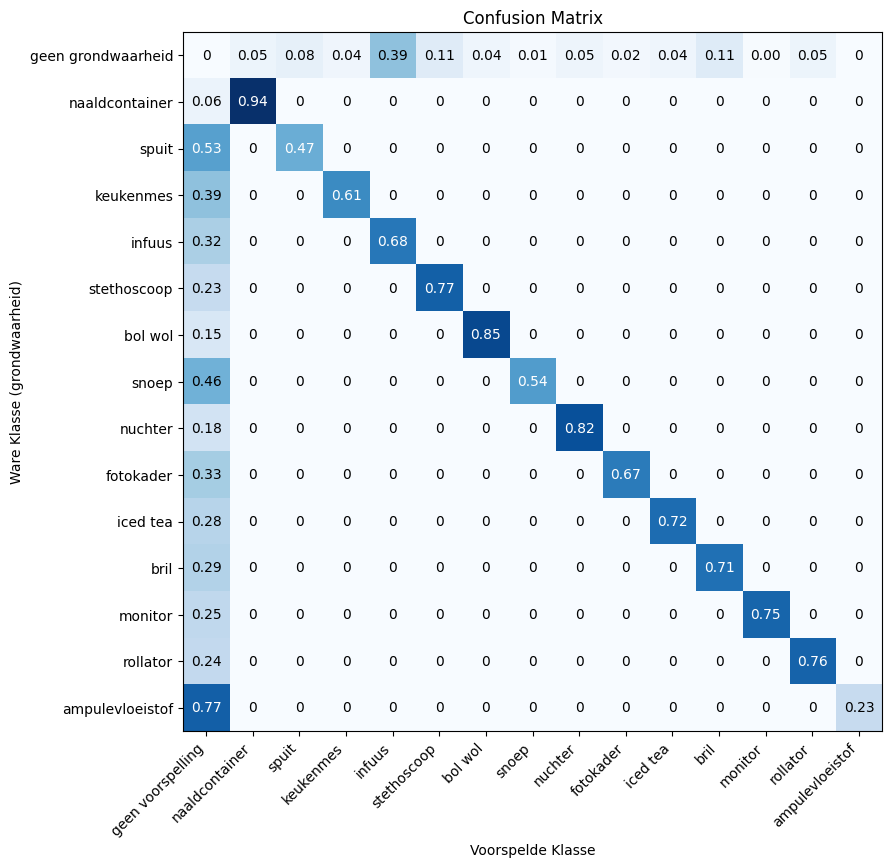

In [7]:
best_grid_search_result = get_best_grid_search_result(
    grid_search_results=grid_search_results, metric="micro_f1"
)

render_grid_search_result(result=best_grid_search_result)


Beste resultaat voor model same_background_640_500:
  Min Pred Conf: 0.85
  IoU Threshold: 0.3
  Min Observed Frames: 0
  Micro F1: 0.7998
  Micro Precision: 0.9482
  Micro Recall: 0.6915

Beste resultaat voor model same_background_640_1000:
  Min Pred Conf: 0.85
  IoU Threshold: 0.2
  Min Observed Frames: 3
  Micro F1: 0.8017
  Micro Precision: 0.9424
  Micro Recall: 0.6976

Beste resultaat voor model same_background_640_2000:
  Min Pred Conf: 0.85
  IoU Threshold: 0.2
  Min Observed Frames: 5
  Micro F1: 0.7974
  Micro Precision: 0.9437
  Micro Recall: 0.6904

Beste resultaat voor model same_background_640_3000:
  Min Pred Conf: 0.85
  IoU Threshold: 0.3
  Min Observed Frames: 3
  Micro F1: 0.7994
  Micro Precision: 0.9521
  Micro Recall: 0.6889



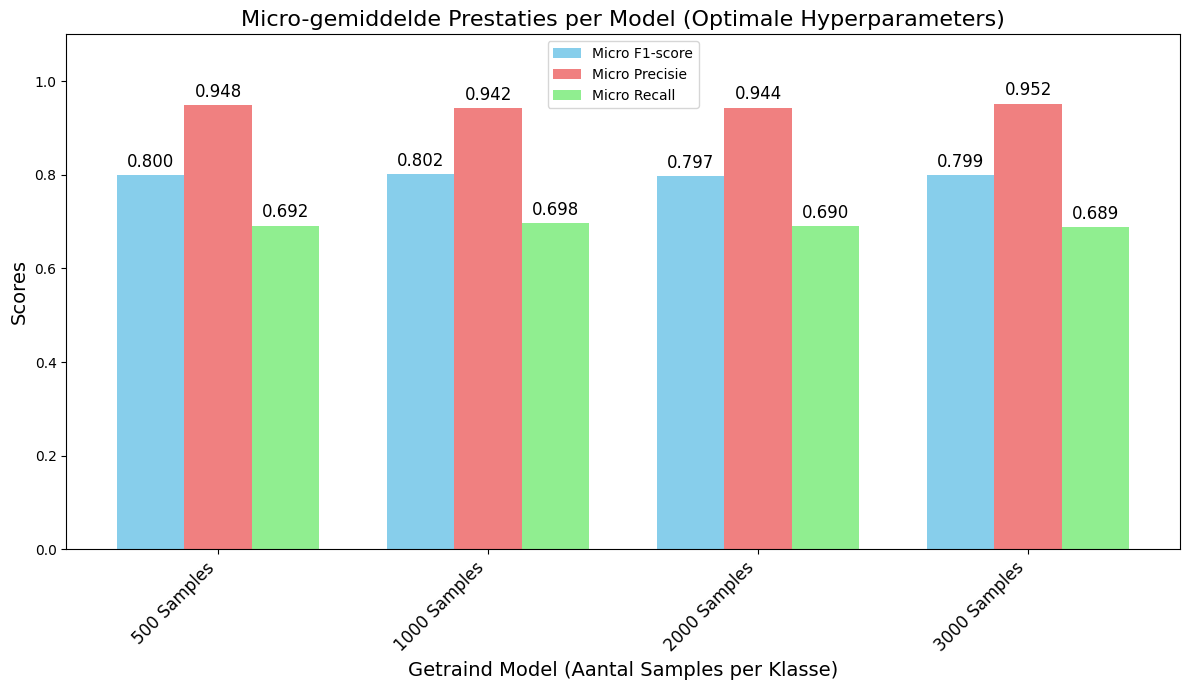

In [43]:
model_names_short = []
f1_scores = []
precision_scores = []
recall_scores = []

models = sorted(models, key=lambda x: int(x.stem.split("_")[-1]))

for model_path in models: # Gebruik 'model_path' om consistent te zijn met je eerdere code
    model_name_full = model_path.stem # bv. "same_background_640_500"
    
    # Extraheer het aantal samples voor de x-as label
    try:
        # Probeer het laatste deel te pakken, ervan uitgaande dat dit het aantal samples is
        num_samples = model_name_full.split("_")[-1]
        model_names_short.append(f"{num_samples} Samples")
    except IndexError:
        model_names_short.append(model_name_full) # Fallback naar volledige naam

    model_results_for_current_model = [
        result for result in grid_search_results if result["model_name"] == model_name_full
    ]
    
    if not model_results_for_current_model:
        print(f"Waarschuwing: Geen resultaten gevonden voor model {model_name_full}")
        f1_scores.append(0) # Voeg dummy waarden toe om de grafiek te kunnen maken
        precision_scores.append(0)
        recall_scores.append(0)
        continue

    best_result = get_best_grid_search_result(
        grid_search_results=model_results_for_current_model, metric="micro_f1"
    )
    cm_metrics = best_result["cm_metrics"]

    f1_scores.append(cm_metrics.micro_f1)
    precision_scores.append(cm_metrics.micro_precision)
    recall_scores.append(cm_metrics.micro_recall)

    # Print de beste resultaten (optioneel, maar handig voor verificatie)
    print(f"Beste resultaat voor model {model_name_full}:")
    print(f"  Min Pred Conf: {best_result['min_pred_conf']}")
    print(f"  IoU Threshold: {best_result['iou_threshold']}")
    print(f"  Min Observed Frames: {best_result['min_observed_frames']}") # Hernoemd van 'glance'
    print(f"  Micro F1: {cm_metrics.micro_f1:.4f}")
    print(f"  Micro Precision: {cm_metrics.micro_precision:.4f}")
    print(f"  Micro Recall: {cm_metrics.micro_recall:.4f}\n")


# Maak de bar chart
x = np.arange(len(model_names_short))  # de label locaties
width = 0.25  # de breedte van de bars

fig, ax = plt.subplots(figsize=(12, 7)) # Maak figuur en assen, pas grootte aan
rects1 = ax.bar(x - width, f1_scores, width, label='Micro F1-score', color='skyblue')
rects2 = ax.bar(x, precision_scores, width, label='Micro Precisie', color='lightcoral')
rects3 = ax.bar(x + width, recall_scores, width, label='Micro Recall', color='lightgreen')

# Voeg wat tekst toe voor labels, titel en custom x-as tick labels, etc.
ax.set_ylabel('Scores', fontsize=14)
ax.set_xlabel('Getraind Model (Aantal Samples per Klasse)', fontsize=14)
ax.set_title('Micro-gemiddelde Prestaties per Model (Optimale Hyperparameters)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(model_names_short, rotation=45, ha="right", fontsize=12) # Roteer labels voor leesbaarheid
ax.legend()

# Functie om labels boven de bars toe te voegen (optioneel)
def autolabel(rects):
    """Bevestig een tekstlabel boven elke bar in *rects*, met de hoogte ervan."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 punten verticale offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

ax.set_ylim(0, 1.1) # Zorg dat y-as tot net boven 1.0 gaat
fig.tight_layout() # Zorgt dat alles netjes past

plt.show()

# Per-class Results

In [9]:
def get_class_id_to_color(session):
    calibration_id = simrooms_repo.get_calibration_recording(
        session, simroom_id=SIMROOM_ID, recording_id="d6fd0aed-b901-4863-bad8-7910dad693e0"
    ).id

    tracked_classes = simrooms_repo.get_tracked_classes(session, calibration_id)

    class_id_to_color = {}
    for cls_ in tracked_classes:
        class_id_to_color[cls_.id] = cls_.color

    return class_id_to_color

naaldcontainer 42 715
spuit 243 460
keukenmes 161 416
infuus 147 465
stethoscoop 130 557
bol wol 65 442
snoep 165 360
nuchter 69 393
fotokader 129 389
iced tea 92 331
bril 111 381
monitor 128 506
rollator 85 349
ampulevloeistof 290 376


/tmp/ipykernel_7082/453339618.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_class_names, rotation=45, ha="right", fontsize=12)  # Optional redundancy
/tmp/ipykernel_7082/453339618.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_class_names, rotation=45, ha="right", fontsize=12)  # Optional redundancy


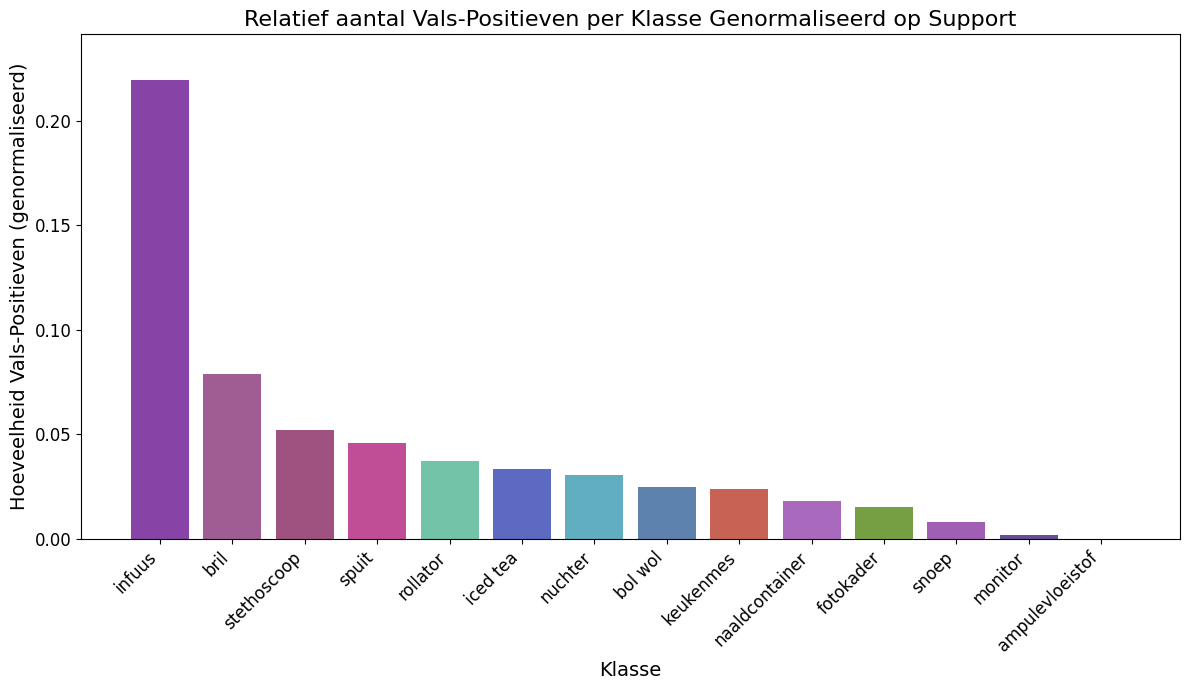

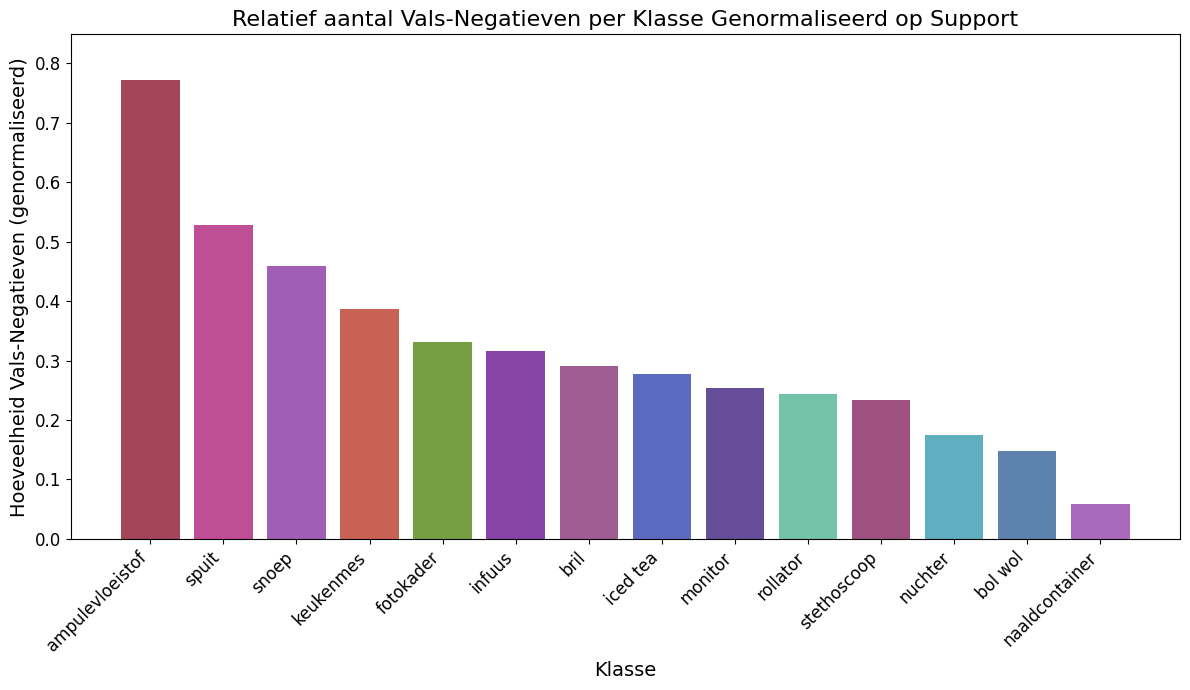

In [47]:
with Session(engine) as session:
    class_id_to_color = get_class_id_to_color(Session(bind=engine))


cm = best_grid_search_result["cm"]
cm_metrics: CMMetrics = best_grid_search_result["cm_metrics"]
per_class_metrics = cm_metrics.per_class_metrics

class_ids = []
recall_scores = []
fp_counts = []
fn_counts = []

for class_metrics in per_class_metrics:
    class_id = class_metrics.class_id
    class_ids.append(class_metrics.class_id)

    fp_count = cm.at[MISSING_GROUND_TRUTH_CLASS_ID, class_id]
    support = class_metrics.support
    normalized_fp_count = fp_count / support if support > 0 else 0
    fp_counts.append(normalized_fp_count)

    fn_count = cm.at[class_id, MISSING_PREDICTION_CLASS_ID]
    print(CLASS_ID_TO_NAME[class_id], fn_count, support)
    normalized_fn_count = fn_count / support if support > 0 else 0
    fn_counts.append(normalized_fn_count)


# Create a plot for false positives per class, sort by false positive count, give color based on class_id_to_color, x labels should be class names from CLASS_ID_TO_NAME
# DO NOT CREATE A PLOT FOR RECALL HERE
sorted_indices = np.argsort(fp_counts)[::-1] 
sorted_class_ids = [class_ids[i] for i in sorted_indices]
sorted_fp_counts = [fp_counts[i] for i in sorted_indices]
# Create a color list based on class_id_to_color
sorted_class_names = [CLASS_ID_TO_NAME[class_id] for class_id in sorted_class_ids]
colors = [class_id_to_color[class_id] for class_id in sorted_class_ids]

fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(
    sorted_class_names,      # Use class names as x-values
    sorted_fp_counts,
    color=colors,
)
ax.set_xlabel("Klasse", fontsize=14)
ax.set_ylabel("Hoeveelheid Vals-Positieven (genormaliseerd)", fontsize=14)
ax.set_title("Relatief aantal Vals-Positieven per Klasse Genormaliseerd op Support", fontsize=16)
ax.set_xticklabels(sorted_class_names, rotation=45, ha="right", fontsize=12)  # Optional redundancy
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(0, max(sorted_fp_counts) * 1.1)
plt.tight_layout()

# Create a plot for the false-negatives per class in the same way
sorted_indices = np.argsort(fn_counts)[::-1] 
sorted_class_ids = [class_ids[i] for i in sorted_indices]
sorted_fn_counts = [fn_counts[i] for i in sorted_indices]
sorted_class_names = [CLASS_ID_TO_NAME[class_id] for class_id in sorted_class_ids]
colors = [class_id_to_color[class_id] for class_id in sorted_class_ids]

fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(
    sorted_class_names,
    sorted_fn_counts,
    color=colors,
)
ax.set_xlabel("Klasse", fontsize=14)
ax.set_ylabel("Hoeveelheid Vals-Negatieven (genormaliseerd)", fontsize=14)
ax.set_title("Relatief aantal Vals-Negatieven per Klasse Genormaliseerd op Support", fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticklabels(sorted_class_names, rotation=45, ha="right", fontsize=12)  # Optional redundancy
ax.set_ylim(0, max(fn_counts) * 1.1)
plt.tight_layout()



# Further Analysis of Best Model

Number of false positives: 262
Predicted Class ID: 1.0 (naaldcontainer) with 13 false positives


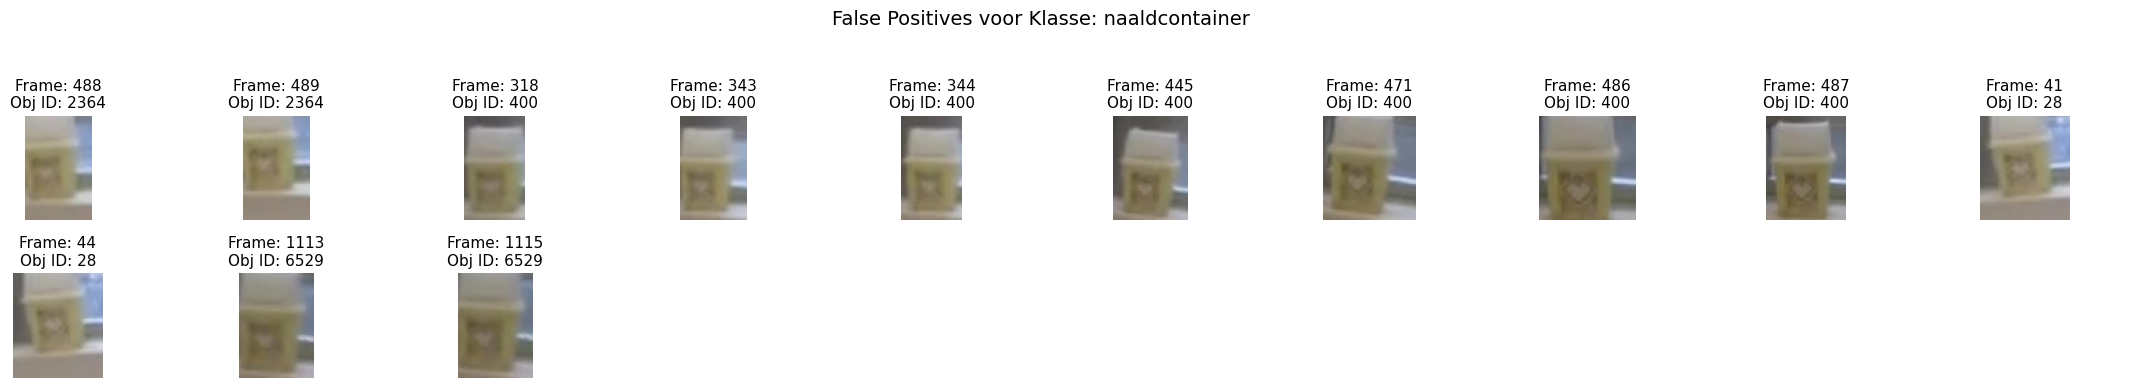

Predicted Class ID: 2.0 (spuit) with 21 false positives


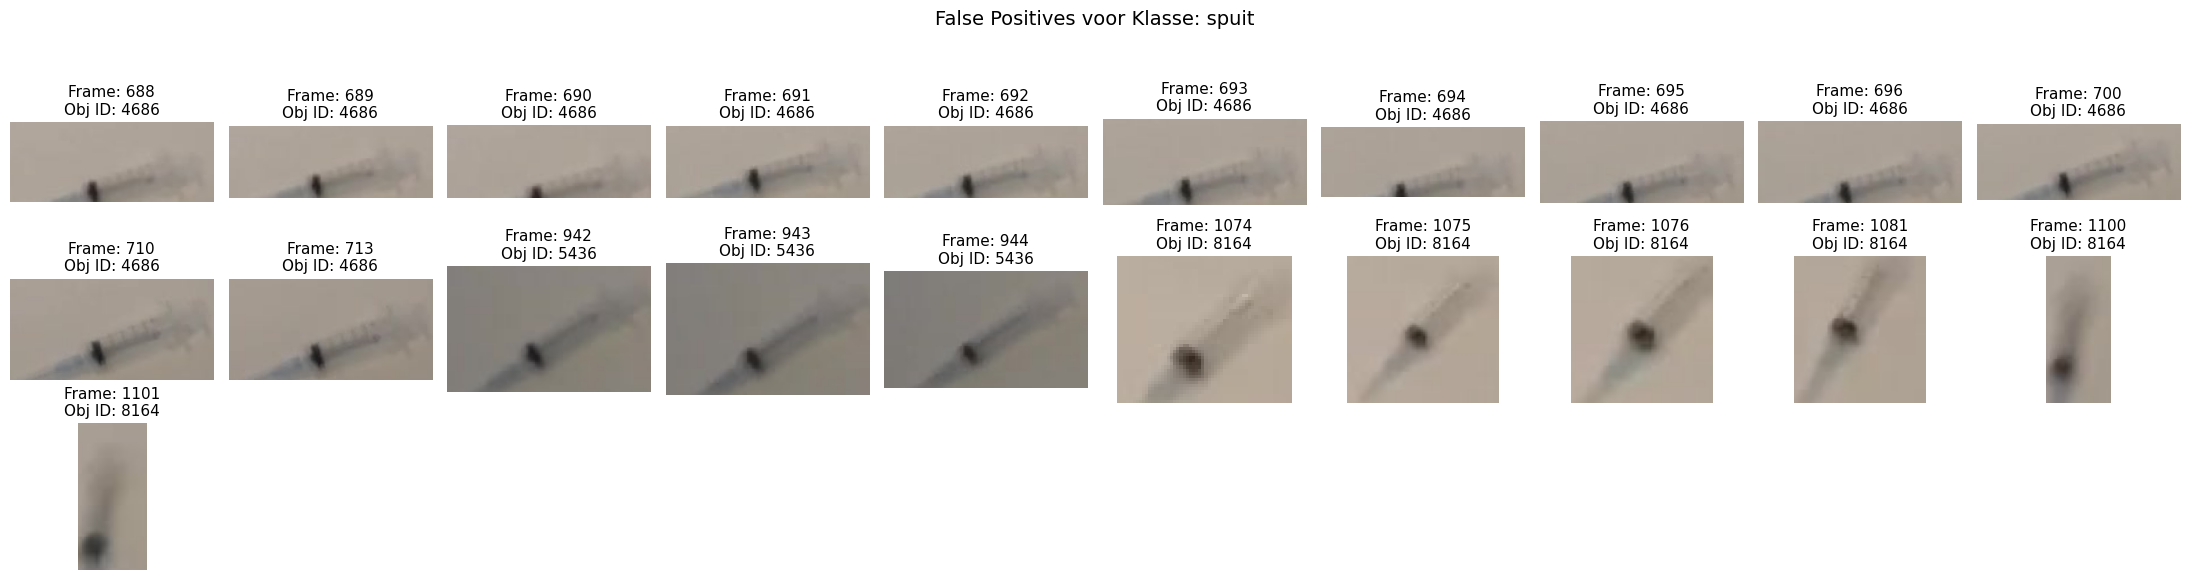

Predicted Class ID: 3.0 (keukenmes) with 10 false positives


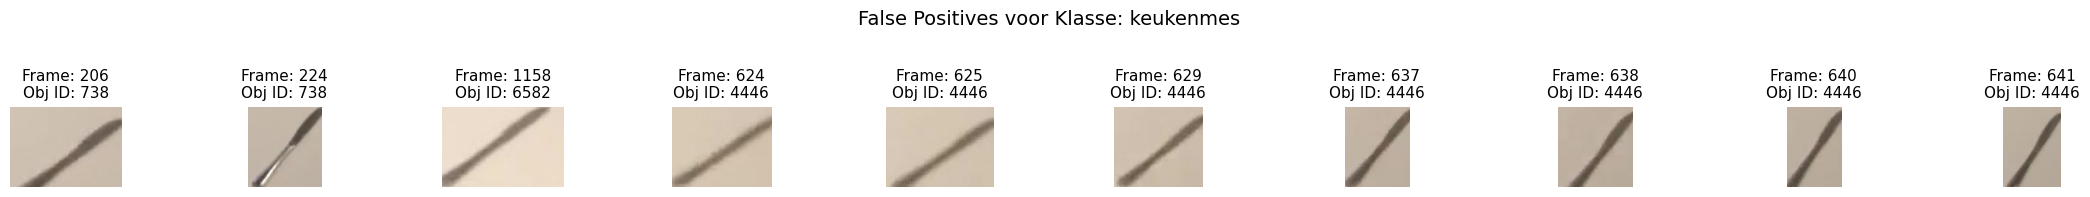

Predicted Class ID: 4.0 (infuus) with 102 false positives


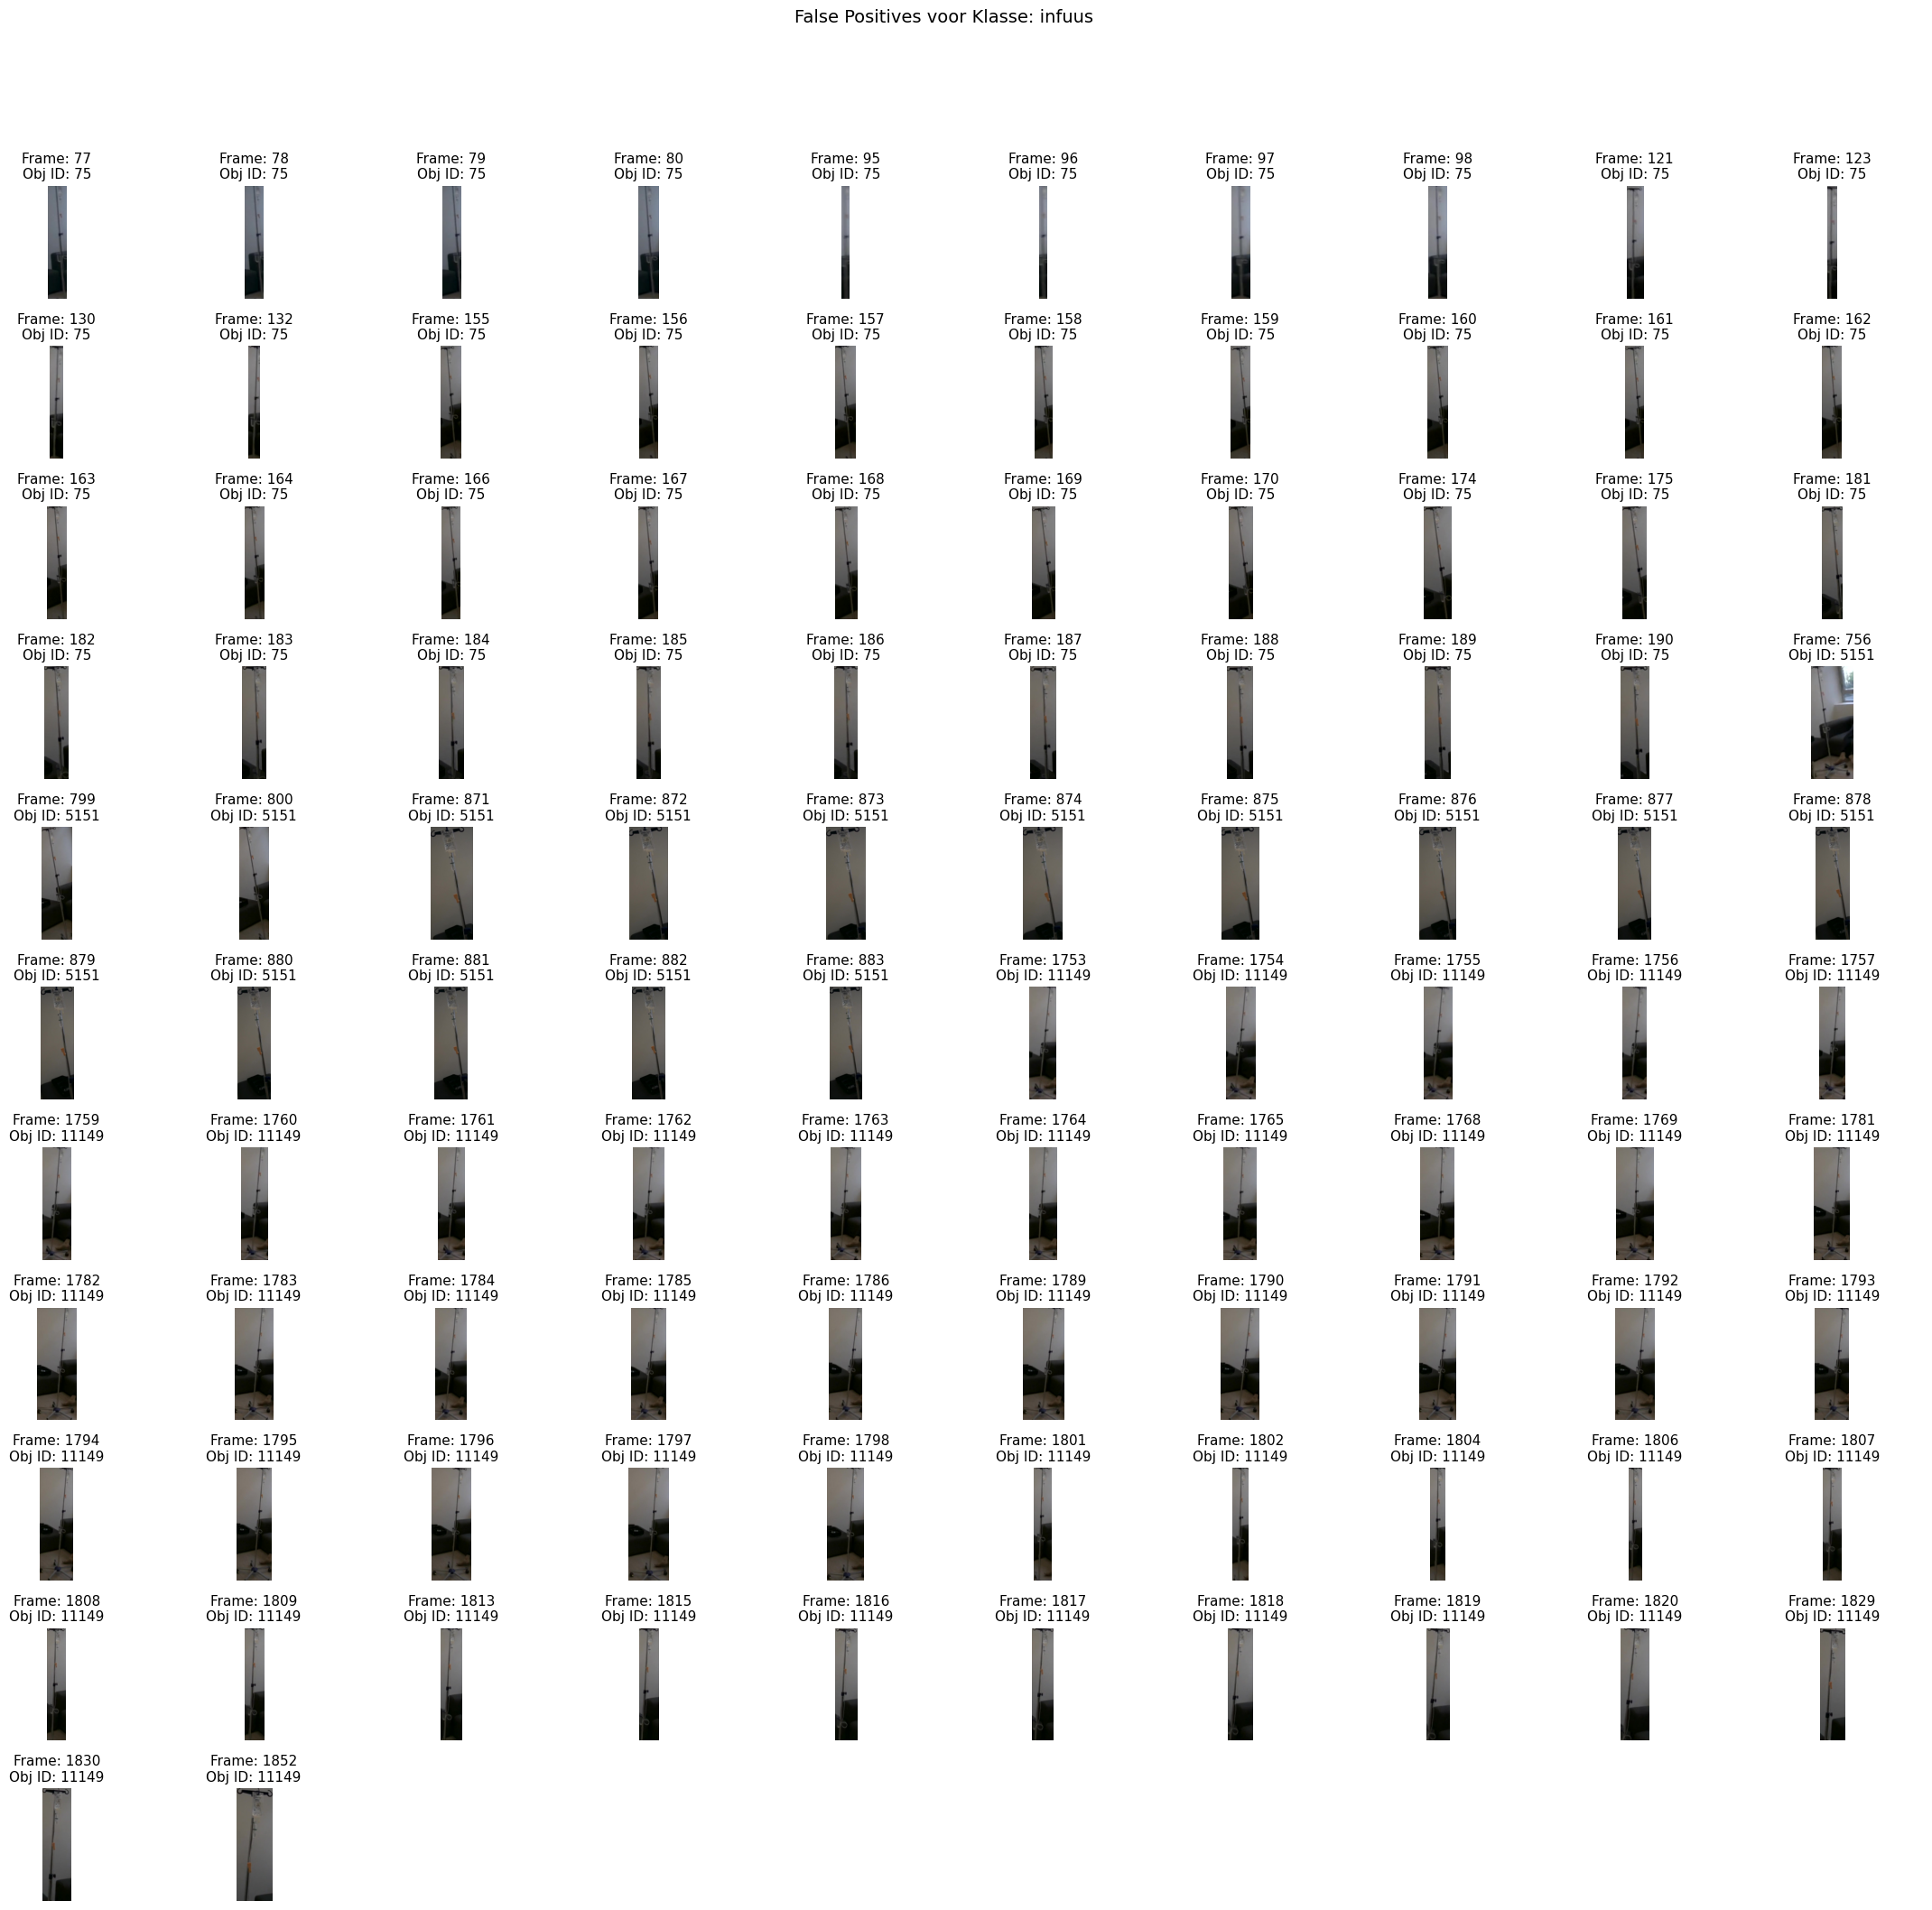

Predicted Class ID: 5.0 (stethoscoop) with 29 false positives


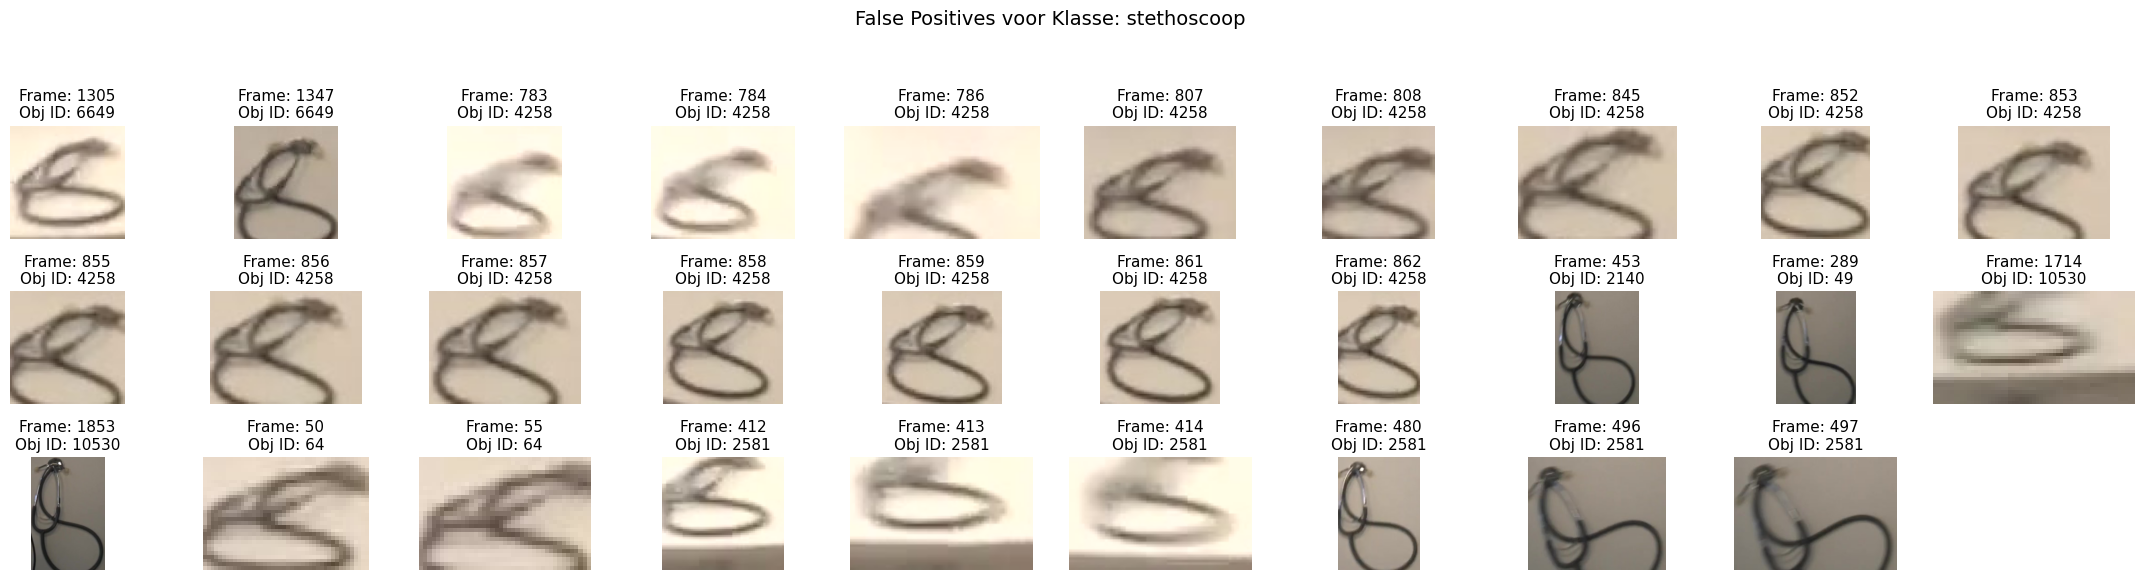

Predicted Class ID: 6.0 (bol wol) with 11 false positives


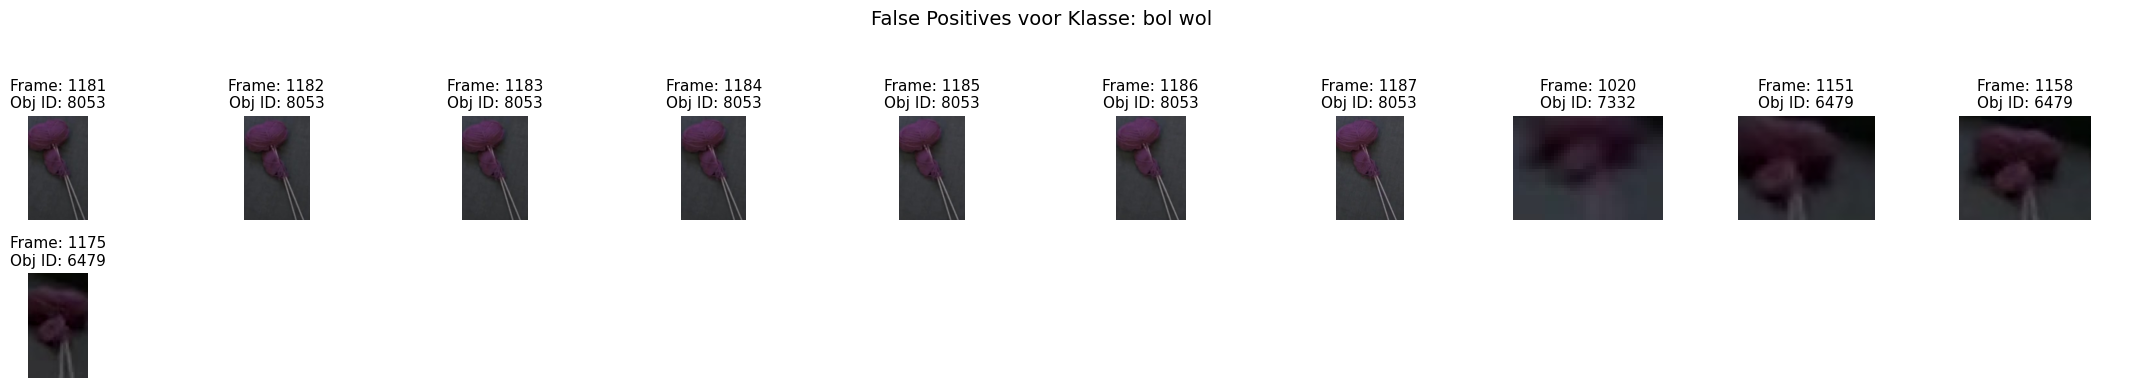

Predicted Class ID: 7.0 (snoep) with 3 false positives


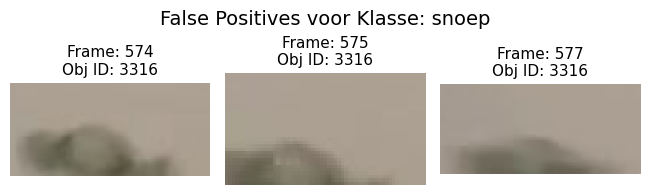

Predicted Class ID: 8.0 (nuchter) with 12 false positives


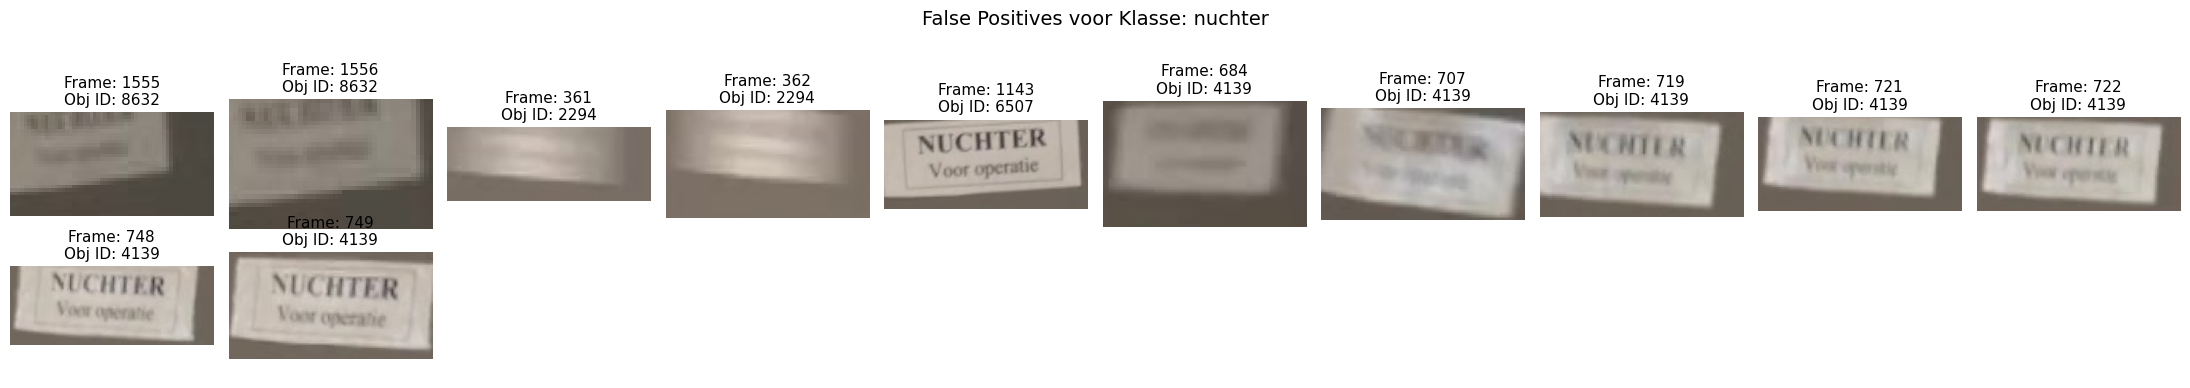

Predicted Class ID: 9.0 (fotokader) with 6 false positives


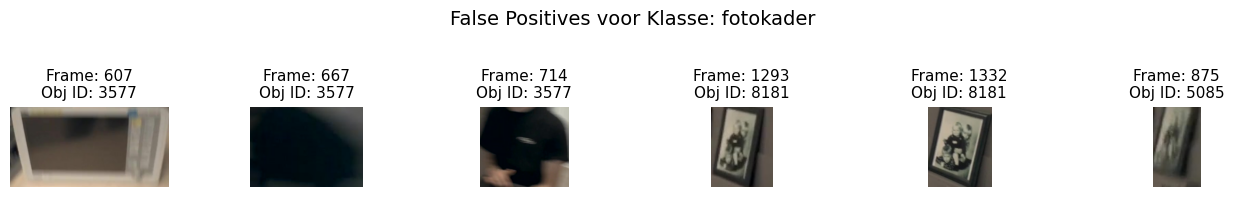

Predicted Class ID: 10.0 (iced tea) with 11 false positives


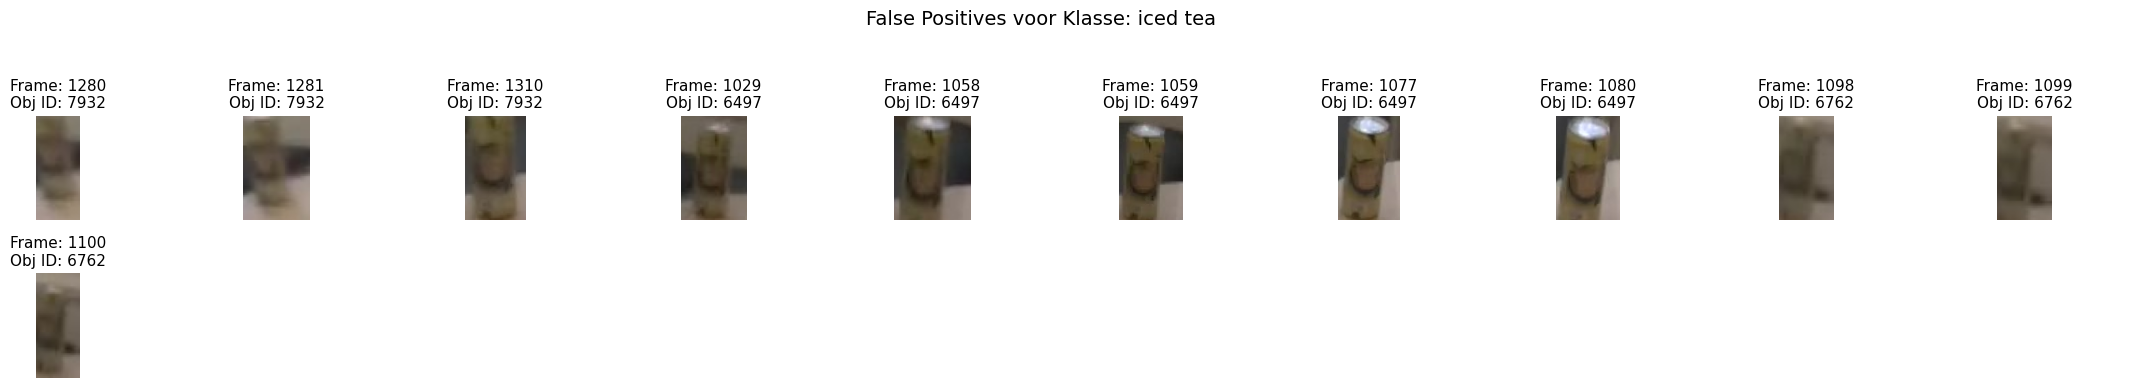

Predicted Class ID: 11.0 (bril) with 30 false positives


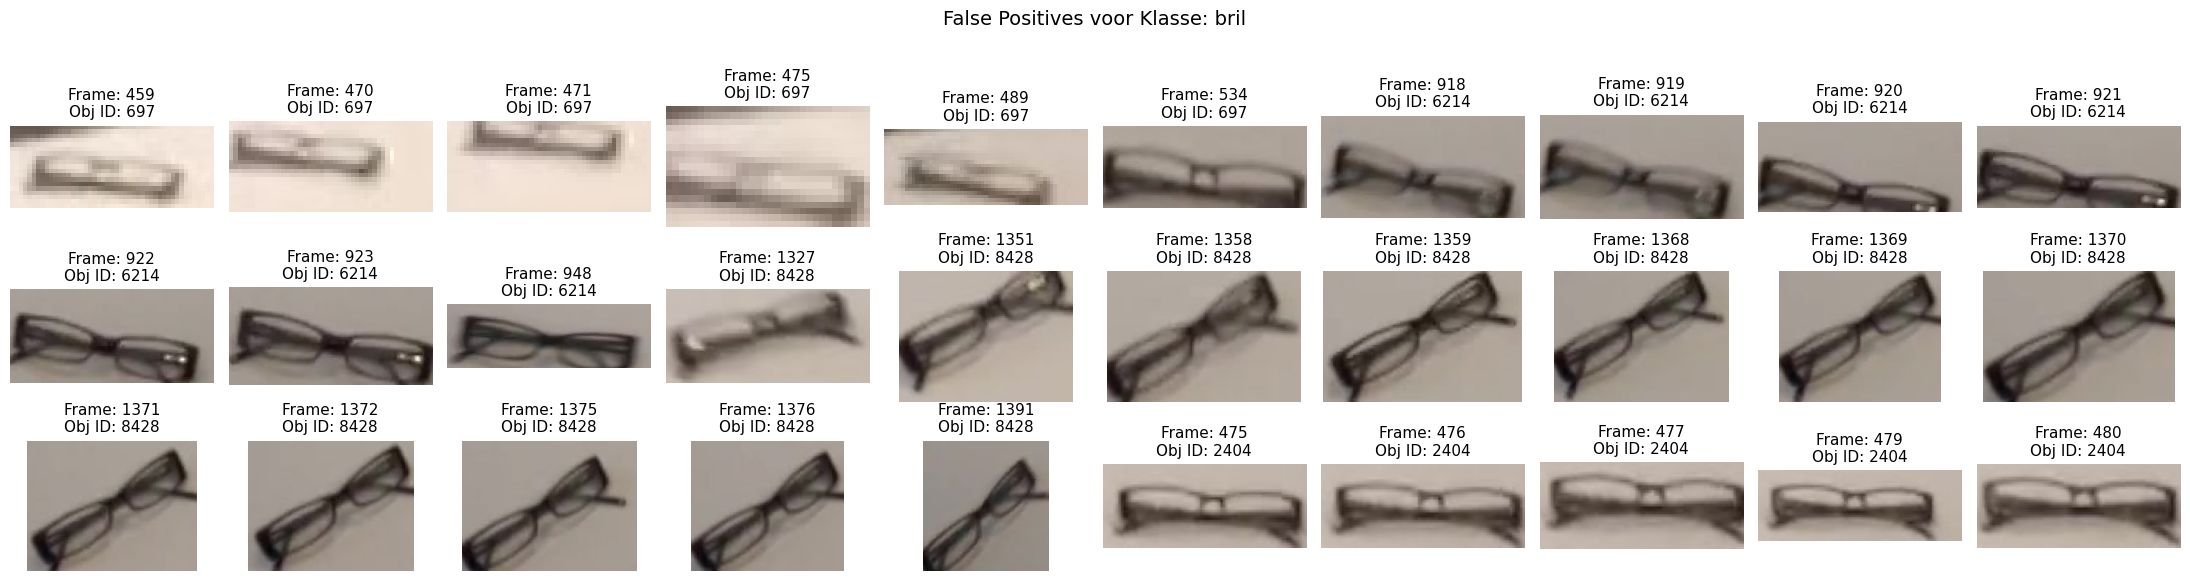

Predicted Class ID: 12.0 (monitor) with 1 false positives


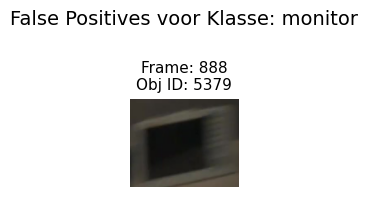

Predicted Class ID: 13.0 (rollator) with 13 false positives


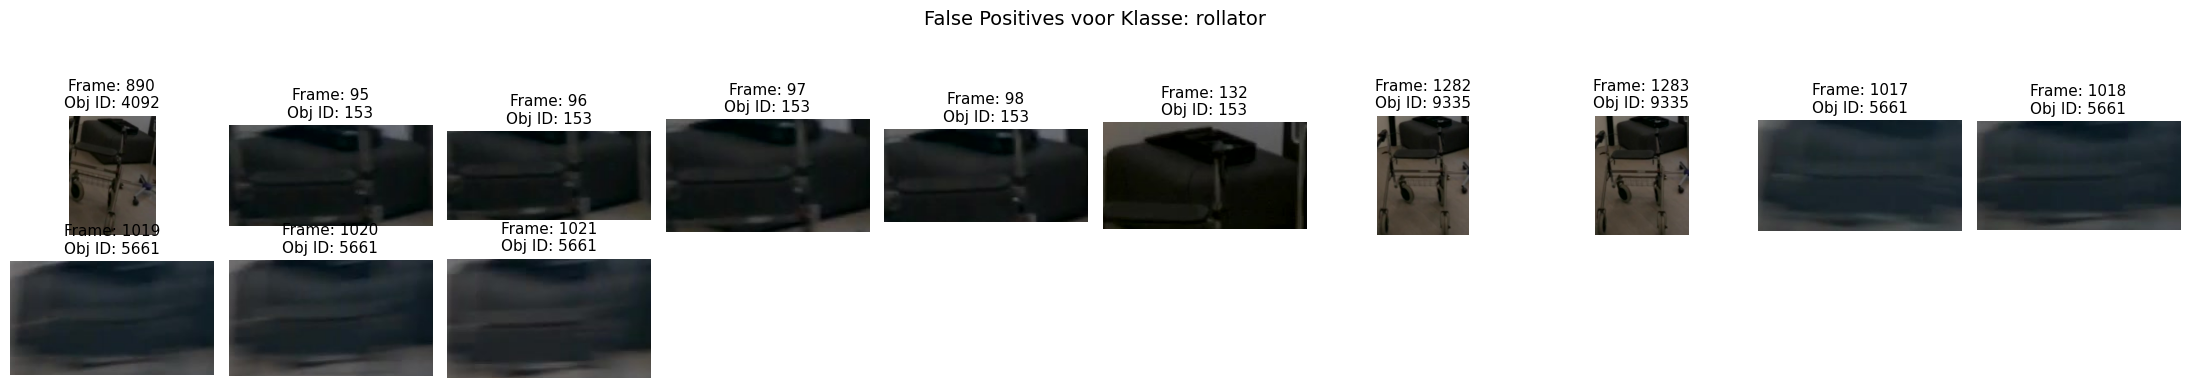

In [17]:
evaluation_df = best_grid_search_result["full_evaluation_df"]
fps_df = evaluation_df[evaluation_df["label"] == "FP"]

print(f"Number of false positives: {len(fps_df)}")

# Group false positives by predicted class instead of recording
for class_id, group in fps_df.groupby("predicted_class_id"):
    print(f"Predicted Class ID: {class_id} ({CLASS_ID_TO_NAME[class_id]}) with {len(group)} false positives")

    rois = []
    frame_indexes = []
    recording_ids = []
    object_ids = []

    for idx, row in group.iterrows():
        recording_id = row["recording_id"]
        frame_idx = row["frame_idx"]
        # Zorg ervoor dat x1, y1, x2, y2 niet NaN zijn voordat je ze naar int converteert
        if pd.isna(row["x1"]) or pd.isna(row["y1"]) or pd.isna(row["x2"]) or pd.isna(row["y2"]):
            print(f"Skipping FP with NaN coordinates: Recording {recording_id}, Frame {frame_idx}, Object ID {row['object_id']}")
            continue
        x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])

        frame_path = RECORDING_FRAMES_PATH / recording_id / f"{int(frame_idx):05d}.jpg"

        image = cv2.imread(str(frame_path))
        if image is None: # Controleer of de afbeelding correct is geladen
            print(f"Warning: Could not read image {frame_path}")
            continue
        
        # Controleer of de ROI coördinaten geldig zijn
        if y1 >= y2 or x1 >= x2 or y1 < 0 or y2 > image.shape[0] or x1 < 0 or x2 > image.shape[1]:
            print(f"Skipping FP with invalid ROI coordinates: Rec {recording_id}, Frame {frame_idx}, Box [{x1},{y1},{x2},{y2}] for image shape {image.shape}")
            continue

        roi = image[y1:y2, x1:x2]
        if roi.size == 0: # Controleer of de ROI niet leeg is
            print(f"Skipping FP with empty ROI: Rec {recording_id}, Frame {frame_idx}, Box [{x1},{y1},{x2},{y2}]")
            continue

        rois.append(roi)
        frame_indexes.append(frame_idx)
        recording_ids.append(recording_id)
        object_ids.append(row["object_id"])

    if not rois: # Als er geen geldige ROIs zijn voor deze klasse, ga naar de volgende
        print(f"No valid ROIs to display for class {CLASS_ID_TO_NAME[class_id]}")
        continue

    # Sort ROIs by frame index (optioneel, als je ze gesorteerd wilt weergeven)
    # Als je wilt sorteren, moet je alle lijsten (rois, frame_indexes, object_ids) tegelijk sorteren:
    # sorted_data = sorted(zip(rois, frame_indexes, object_ids), key=lambda x: x[1])
    # rois, frame_indexes, object_ids = zip(*sorted_data) if sorted_data else ([], [], [])


    n = len(rois)
    max_cols = 10
    n_cols = min(max_cols, n)
    n_rows = (n + n_cols - 1) // n_cols

    if n == 0: # Voorkom fouten als er geen ROIs zijn na filtering
        plt.figure() # Maak een lege figuur om show() niet te laten falen
        plt.suptitle(f"No False Positives to Display for Class: {CLASS_ID_TO_NAME[class_id]}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        continue

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.2 * n_cols, 2 * n_rows), squeeze=False)
    # squeeze=False zorgt ervoor dat 'axes' altijd een 2D array is, zelfs als n_rows of n_cols 1 is.

    # Nu kun je altijd flattenen, omdat het een 2D array is
    axes = axes.flatten()


    for i, roi_img in enumerate(rois): # Hernoemd naar roi_img om conflict met module naam te voorkomen
        axes[i].imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
        axes[i].axis("off")
        axes[i].set_title(
            f"Frame: {int(frame_indexes[i])}\nObj ID: {int(object_ids[i])}", # Kortere titel
            fontsize=11, # Kleinere fontsize voor titel
        )

    # Zet resterende, ongebruikte subplots uit
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(f"False Positives voor Klasse: {CLASS_ID_TO_NAME[class_id]}", fontsize=14) # Iets kleinere suptitle
    plt.tight_layout(rect=[0, 0.02, 1, 0.93]) # Pas rect aan voor meer ruimte voor suptitle en x-labels
    plt.show()

/tmp/ipykernel_165077/929882783.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fps_df_all['predicted_class_id'] = pd.to_numeric(fps_df_all['predicted_class_id'], errors='coerce')


Aantal False Positives voor 'naaldcontainer': 13


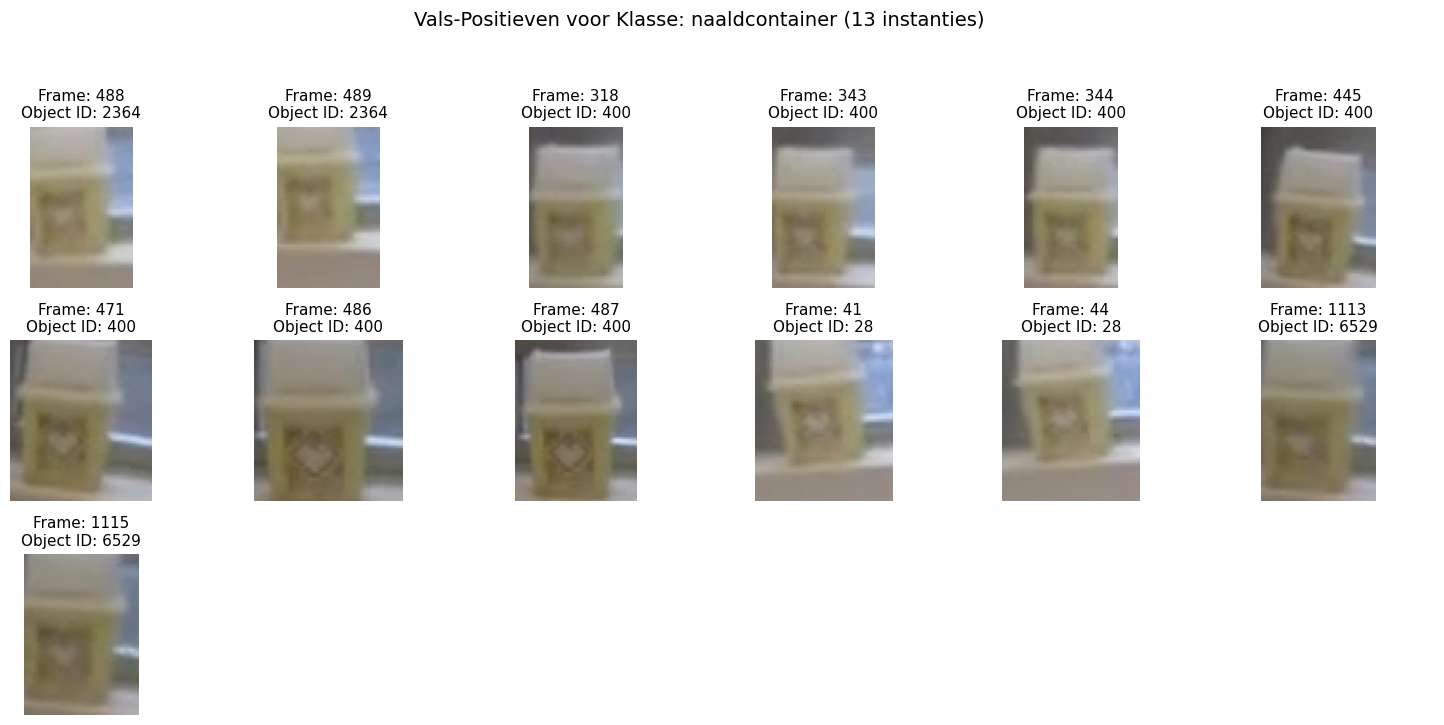

In [42]:
TARGET_CLASS_NAME = "naaldcontainer"
N_COLS = 6 # Aantal kolommen per rij

evaluation_df = best_grid_search_result["full_evaluation_df"]

# Filter op False Positives
fps_df_all = evaluation_df[evaluation_df["label"] == "FP"]

if fps_df_all.empty:
    print("Geen False Positives gevonden in de evaluatiedata.")
else:
    # Filter op de specifieke klasse "naaldcontainer"
    try:
        target_class_id = NAME_TO_CLASS_ID[TARGET_CLASS_NAME]
    except KeyError:
        print(f"Fout: Klasse '{TARGET_CLASS_NAME}' niet gevonden in NAME_TO_CLASS_ID mapping.")
        # Voeg hier eventueel 'exit()' of 'return' toe als dit in een functie staat
        target_class_id = -999 # Een onwaarschijnlijke ID om een lege dataframe te forceren

    # Zorg ervoor dat 'predicted_class_id' numeriek is voor de vergelijking
    fps_df_all['predicted_class_id'] = pd.to_numeric(fps_df_all['predicted_class_id'], errors='coerce')
    
    fps_df_target_class = fps_df_all[fps_df_all["predicted_class_id"] == target_class_id]

    if fps_df_target_class.empty:
        print(f"Geen False Positives gevonden voor de klasse: {TARGET_CLASS_NAME}")
    else:
        print(f"Aantal False Positives voor '{TARGET_CLASS_NAME}': {len(fps_df_target_class)}")

        rois_target = []
        frame_indexes_target = []
        object_ids_target = []

        for idx, row in fps_df_target_class.iterrows():
            recording_id = row["recording_id"]
            frame_idx = row["frame_idx"]
            
            # Controleer op NaN waarden voor coördinaten
            if pd.isna(row["x1"]) or pd.isna(row["y1"]) or pd.isna(row["x2"]) or pd.isna(row["y2"]):
                print(f"  Skipping FP (NaN coördinaten): Opn. {recording_id}, Frame {frame_idx}, Obj ID {row['object_id']}")
                continue
            
            x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])
            frame_path = RECORDING_FRAMES_PATH / str(recording_id) / f"{int(frame_idx):05d}.jpg"

            image = cv2.imread(str(frame_path))
            if image is None:
                print(f"  Waarschuwing: Kon afbeelding niet lezen {frame_path}")
                continue
            
            # Controleer geldigheid ROI coördinaten en grootte
            if not (0 <= y1 < y2 <= image.shape[0] and 0 <= x1 < x2 <= image.shape[1]):
                print(f"  Skipping FP (ongeldige ROI): Opn. {recording_id}, Frame {frame_idx}, Box [{x1},{y1},{x2},{y2}] voor afb. shape {image.shape}")
                continue

            roi = image[y1:y2, x1:x2]
            if roi.size == 0:
                 print(f"  Skipping FP (lege ROI): Opn. {recording_id}, Frame {frame_idx}, Box [{x1},{y1},{x2},{y2}]")
                 continue

            rois_target.append(roi)
            frame_indexes_target.append(frame_idx)
            object_ids_target.append(row["object_id"])
        
        if not rois_target:
            print(f"Geen geldige ROIs om weer te geven voor False Positives van klasse '{TARGET_CLASS_NAME}'.")
        else:
            n_rois = len(rois_target)
            n_rows = (n_rois + N_COLS - 1) // N_COLS # Bereken aantal rijen

            fig, axes = plt.subplots(n_rows, N_COLS, figsize=(2.5 * N_COLS, 2.5 * n_rows), squeeze=False)
            axes_flat = axes.flatten() # Flatten altijd, want squeeze=False

            for i, roi_img in enumerate(rois_target):
                axes_flat[i].imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
                axes_flat[i].axis("off")
                axes_flat[i].set_title(
                    f"Frame: {int(frame_indexes_target[i])}\nObject ID: {int(object_ids_target[i])}",
                    fontsize=11
                )
            
            # Zet resterende, ongebruikte subplots uit
            for j in range(n_rois, len(axes_flat)):
                axes_flat[j].axis("off")

            fig.suptitle(f"Vals-Positieven voor Klasse: {TARGET_CLASS_NAME} ({n_rois} instanties)", fontsize=14)
            plt.tight_layout(rect=[0, 0.02, 1, 0.94]) # rect=[left, bottom, right, top]
            plt.show()

/tmp/ipykernel_165077/2912413661.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fps_df_all['predicted_class_id'] = pd.to_numeric(fps_df_all['predicted_class_id'], errors='coerce')


Totaal aantal False Positives voor 'infuus': 102
Willekeurig 6 van de 102 FP's voor 'infuus' geselecteerd om te tonen.


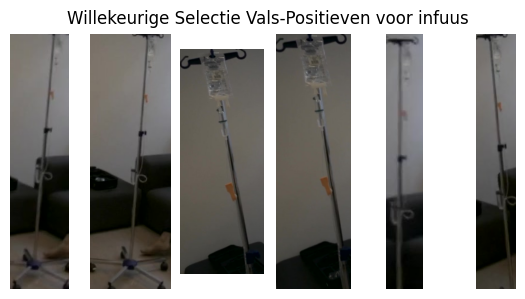

In [41]:
import random

TARGET_CLASS_NAME = "infuus"
N_EXAMPLES_TO_SHOW = 6
N_COLS_FIXED = 6 # We willen altijd 6 kolommen (of minder als er minder voorbeelden zijn)

evaluation_df = best_grid_search_result["full_evaluation_df"]
fps_df_all = evaluation_df[evaluation_df["label"] == "FP"]

if fps_df_all.empty:
    print("Geen False Positives gevonden in de evaluatiedata.")
else:
    try:
        target_class_id = NAME_TO_CLASS_ID[TARGET_CLASS_NAME]
    except KeyError:
        print(f"Fout: Klasse '{TARGET_CLASS_NAME}' niet gevonden in NAME_TO_CLASS_ID mapping.")
        target_class_id = -999

    fps_df_all['predicted_class_id'] = pd.to_numeric(fps_df_all['predicted_class_id'], errors='coerce')
    fps_df_target_class = fps_df_all[fps_df_all["predicted_class_id"] == target_class_id]

    if fps_df_target_class.empty:
        print(f"Geen False Positives gevonden voor de klasse: {TARGET_CLASS_NAME}")
    else:
        print(f"Totaal aantal False Positives voor '{TARGET_CLASS_NAME}': {len(fps_df_target_class)}")

        all_valid_fps_data = [] # Lijst om tuples van (roi, frame_idx, object_id) op te slaan
        for idx, row in fps_df_target_class.iterrows():
            recording_id = row["recording_id"]
            frame_idx = row["frame_idx"]
            
            if pd.isna(row["x1"]) or pd.isna(row["y1"]) or pd.isna(row["x2"]) or pd.isna(row["y2"]):
                continue
            
            x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])
            frame_path = RECORDING_FRAMES_PATH / str(recording_id) / f"{int(frame_idx):05d}.jpg"
            image = cv2.imread(str(frame_path))

            if image is None:
                continue
            
            if not (0 <= y1 < y2 <= image.shape[0] and 0 <= x1 < x2 <= image.shape[1]):
                continue

            roi = image[y1:y2, x1:x2]
            if roi.size == 0:
                 continue
            
            all_valid_fps_data.append((roi, frame_idx, row["object_id"]))
        
        if not all_valid_fps_data:
            print(f"Geen geldige ROIs om weer te geven voor False Positives van klasse '{TARGET_CLASS_NAME}'.")
        else:
            # Selecteer willekeurig N voorbeelden
            if len(all_valid_fps_data) > N_EXAMPLES_TO_SHOW:
                selected_fps_data = random.sample(all_valid_fps_data, N_EXAMPLES_TO_SHOW)
                print(f"Willekeurig {N_EXAMPLES_TO_SHOW} van de {len(all_valid_fps_data)} FP's voor '{TARGET_CLASS_NAME}' geselecteerd om te tonen.")
            else:
                selected_fps_data = all_valid_fps_data
                print(f"Alle {len(all_valid_fps_data)} FP's voor '{TARGET_CLASS_NAME}' worden getoond (minder dan of gelijk aan {N_EXAMPLES_TO_SHOW}).")

            n_rois_to_plot = len(selected_fps_data)
            
            # Bepaal aantal kolommen en rijen voor de plot
            # Als er minder dan N_COLS_FIXED voorbeelden zijn, gebruik dan het werkelijke aantal als kolommen
            current_n_cols = min(n_rois_to_plot, N_COLS_FIXED) 
            if current_n_cols == 0: # Voorkom ZeroDivisionError als n_rois_to_plot 0 is
                 n_rows = 0
            else:
                n_rows = (n_rois_to_plot + current_n_cols - 1) // current_n_cols


            if n_rois_to_plot > 0 :
                fig_width = current_n_cols # Kleinere breedte per subplot voor strakkere layout
                fig_height = 3 * n_rows # Hoogte is afhankelijk van ROI-hoogte
                
                fig, axes = plt.subplots(n_rows, current_n_cols, figsize=(fig_width, fig_height), squeeze=False)
                axes_flat = axes.flatten()

                for i, (roi_img, frame_idx_val, object_id_val) in enumerate(selected_fps_data):
                    axes_flat[i].imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
                    axes_flat[i].axis("off")

                for j in range(n_rois_to_plot, len(axes_flat)):
                    axes_flat[j].axis("off")

                fig.suptitle(f"Willekeurige Selectie Vals-Positieven voor {TARGET_CLASS_NAME}", fontsize=12)
                plt.subplots_adjust(wspace=0.1, hspace=0.1, left=0.05, right=0.95, top=0.90, bottom=0.05) # Strakkere layout
                plt.show()
            else:
                print(f"Geen FP's geselecteerd om te plotten voor {TARGET_CLASS_NAME}")

# Analyze False Negatives in best result

In [10]:
best_result = get_best_grid_search_result(
    grid_search_results=grid_search_results, metric="micro_f1"
)

with Session(engine) as session:
    class_id_to_color = get_class_id_to_color(Session(bind=engine))


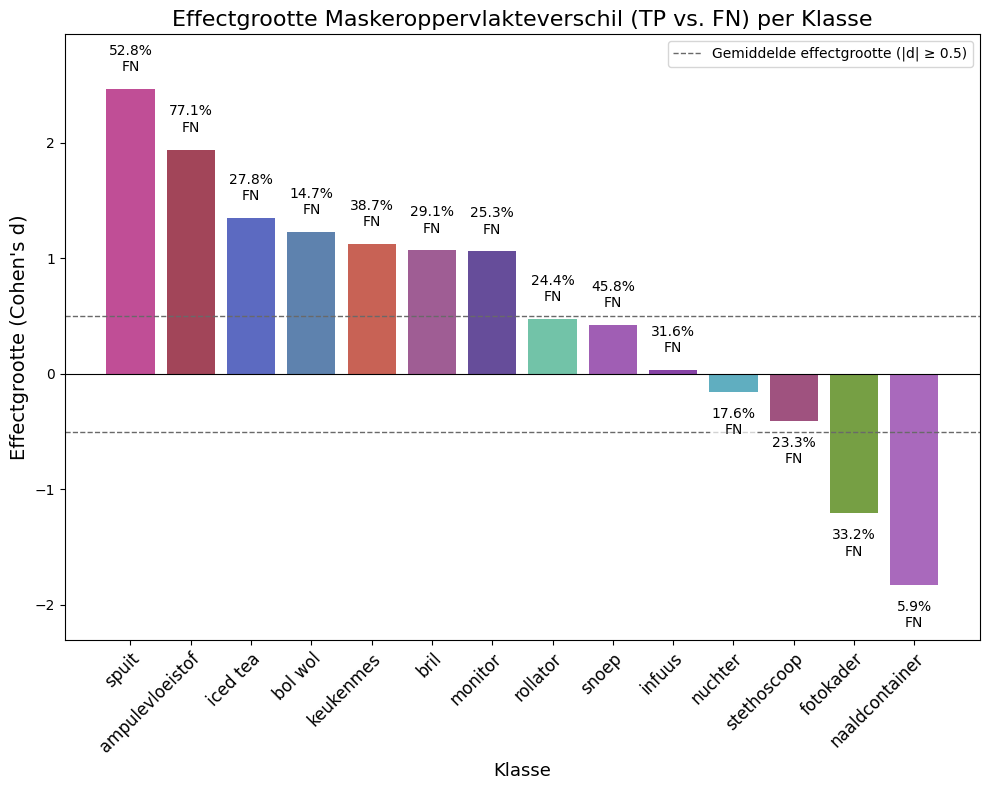

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Vooronderstellingen ---
# evaluation_df, CLASS_ID_TO_NAME, class_id_to_color zijn gedefinieerd
# --- Einde vooronderstellingen ---

def cohen_d(x, y):
    """Bereken Cohen's d voor onafhankelijke groepen."""
    nx = len(x)
    ny = len(y)
    
    if nx < 2 or ny < 2:
        return np.nan

    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)
    
    dof = nx + ny - 2
    if dof <= 0: # Mocht niet gebeuren met nx,ny >=2
        return np.nan

    # Voorkom ZeroDivisionError als std_x en std_y beide 0 zijn
    if std_x == 0 and std_y == 0:
        # Als beide groepen geen variantie hebben (alle waarden gelijk)
        pooled_std = 0.0
    else:
        # pooled_std kan 0 zijn als een groep 0 variantie heeft en maar 1 sample (maar we checken op N>=2)
        # of als door afronding de teller 0 wordt
        numerator_pooled_std = (nx - 1) * std_x**2 + (ny - 1) * std_y**2
        if numerator_pooled_std < 1e-9: # Drempel voor effectief nul
             pooled_std = 0.0
        else:
             pooled_std = np.sqrt(numerator_pooled_std / dof)


    if pooled_std == 0: # of heel dichtbij nul
        return 0.0 if abs(mean_x - mean_y) < 1e-9 else (np.inf if mean_x > mean_y else -np.inf)
            
    return (mean_x - mean_y) / pooled_std

# Data voorbereiden
tp_df = evaluation_df[evaluation_df["label"] == "TP"]
fn_df = evaluation_df[evaluation_df["label"] == "FN"]

effect_size_results = []
all_class_ids = sorted(list(set(tp_df["true_class_id"]) | set(fn_df["true_class_id"])))

MIN_SAMPLES_COHEN_D = 2

for class_id in all_class_ids:
    tp_areas_series = tp_df[tp_df["true_class_id"] == class_id]["mask_area"].dropna()
    fn_areas_series = fn_df[fn_df["true_class_id"] == class_id]["mask_area"].dropna()

    n_tp = len(tp_areas_series)
    n_fn = len(fn_areas_series)

    if n_tp >= MIN_SAMPLES_COHEN_D and n_fn >= MIN_SAMPLES_COHEN_D:
        d = cohen_d(tp_areas_series, fn_areas_series)
        effect_size_results.append({
            "class_id": class_id,
            "class_name": CLASS_ID_TO_NAME.get(class_id, str(class_id)),
            "effect_size": d,
            "n_tp": n_tp,
            "n_fn": n_fn
        })

df_effects = pd.DataFrame(effect_size_results)
df_effects = df_effects.dropna(subset=['effect_size'])
df_effects = df_effects[np.isfinite(df_effects['effect_size'])]

if not df_effects.empty: # Ga alleen verder als er data is om te plotten
    df_effects["fn_percentage"] = df_effects.apply(
        lambda row: (row["n_fn"] / (row["n_tp"] + row["n_fn"])) * 100 if (row["n_tp"] + row["n_fn"]) > 0 else 0,
        axis=1
    )
    df_effects = df_effects.sort_values("effect_size", ascending=False)

    # Bepaal de datarange voor de y-as VOORDAT de plot wordt gemaakt
    min_bar_height = df_effects["effect_size"].min()
    max_bar_height = df_effects["effect_size"].max()

    # Zorg dat 0 in beeld is als data eromheen ligt
    plot_min_y_data = min(min_bar_height, 0) if max_bar_height > 0 else min_bar_height
    plot_max_y_data = max(max_bar_height, 0) if min_bar_height < 0 else max_bar_height
    
    y_data_range = plot_max_y_data - plot_min_y_data
    if y_data_range == 0: # Als alle bars dezelfde hoogte hebben (of 1 bar)
        y_data_range = abs(plot_max_y_data) * 0.4 if plot_max_y_data != 0 else 0.2

    # Minimale absolute offset voor tekst, geschaald met de datarange
    min_abs_text_offset = y_data_range * 0.03

    # Plotten
    fig, ax = plt.subplots(figsize=(max(10, len(df_effects) * 0.7), 8))

    bar_colors = [class_id_to_color.get(cid, 'grey') for cid in df_effects["class_id"]]
    bars = ax.bar(df_effects["class_name"], df_effects["effect_size"], color=bar_colors)

    ax.axhline(0, color="black", linestyle="-", linewidth=0.8)
            
    d_gemiddelde_threshold = 0.5
    ax.axhline(d_gemiddelde_threshold, color="dimgray", linestyle="--", linewidth=1, label=f"Gemiddelde effectgrootte (|d| ≥ {d_gemiddelde_threshold})")
    ax.axhline(-d_gemiddelde_threshold, color="dimgray", linestyle="--", linewidth=1)
  
    ax.set_ylabel("Effectgrootte (Cohen's d)", fontsize=14)
    ax.set_xlabel("Klasse", fontsize=13)
    ax.set_title("Effectgrootte Maskeroppervlakteverschil (TP vs. FN) per Klasse", fontsize=16)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        fn_perc = df_effects.iloc[i]["fn_percentage"]
        
        if height >= 0:
            va_align = 'bottom'
            base_offset_sign = 1
        else:
            va_align = 'top'
            base_offset_sign = -1
        
        offset_value = max(abs(height) * 0.05, min_abs_text_offset) 
        text_y_pos = height + (base_offset_sign * offset_value)

        # Correctie als bar dicht bij nul is en offset tekst eroverheen duwt
        if height >= 0 and text_y_pos < height + min_abs_text_offset * 0.1 : 
            text_y_pos = height + min_abs_text_offset * 0.5 # Zorg voor minimale afstand
        elif height < 0 and text_y_pos > height - min_abs_text_offset * 0.1:
            text_y_pos = height - min_abs_text_offset * 0.5

        ax.text(bar.get_x() + bar.get_width()/2., text_y_pos,
                f"{fn_perc:.1f}%\nFN",
                ha='center', va=va_align, fontsize=10, color='black',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.0))

    if len(df_effects) > 5:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=12)

    ax.legend(loc='upper right') 
    
    # Y-limieten aanpassen om ruimte te maken voor de tekst annotaties
    # Gebruik 15% van de y_data_range als marge aan boven- en onderkant
    margin = y_data_range * 0.11
    ax.set_ylim(plot_min_y_data - margin, plot_max_y_data + margin)
    
    plt.tight_layout()
    plt.show()
else:
    print("Geen data om effectgrootte te plotten (na filteren van NaN/Inf waarden of te weinig samples).")

/tmp/ipykernel_18249/160668370.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violinplot = sns.violinplot(x="type", y="area", data=plot_df, ax=ax, palette=palette,
/tmp/ipykernel_18249/160668370.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violinplot = sns.violinplot(x="type", y="area", data=plot_df, ax=ax, palette=palette,
/tmp/ipykernel_18249/160668370.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violinplot = sns.violinplot(x="type", y="area", data=plot_df, ax=ax, palette=palette,
/tmp/ipykernel_18249/160668370.py:96: FutureWarning: 

Passing `palette` 

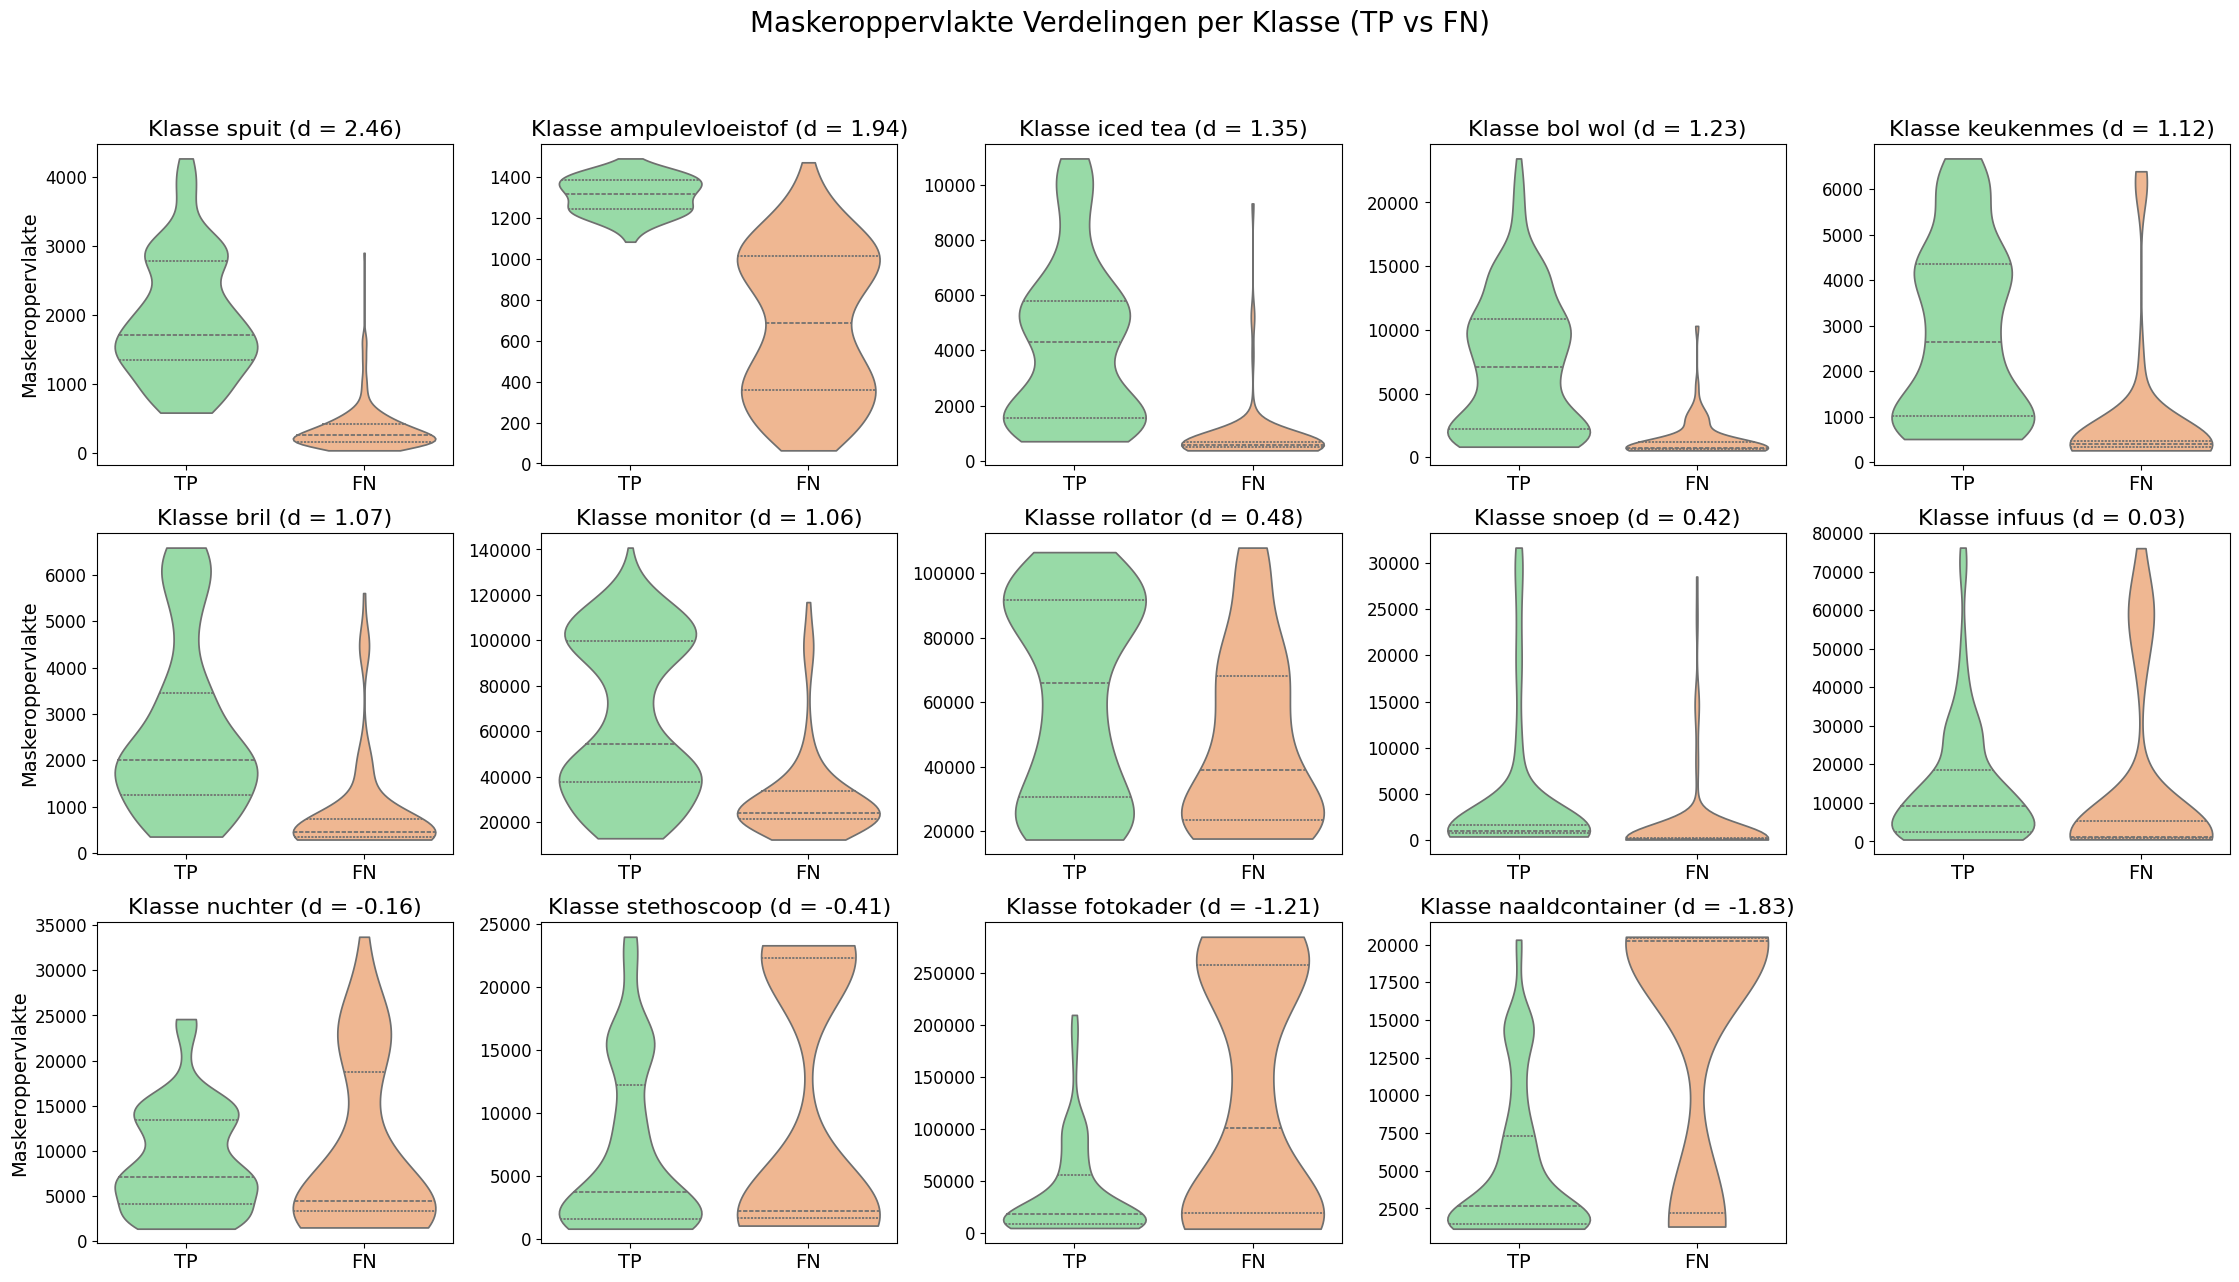

In [79]:
evaluation_df = best_result["full_evaluation_df"]
tp_df_all = evaluation_df[evaluation_df["label"] == "TP"]
fn_df_all = evaluation_df[evaluation_df["label"] == "FN"]

class_effects = []
all_true_class_ids_initial = sorted(evaluation_df["true_class_id"].unique())
MIN_SAMPLES_COHEN_D = 2

for class_id_val in all_true_class_ids_initial:
    tp_areas = tp_df_all[tp_df_all["true_class_id"] == class_id_val]["mask_area"].dropna()
    fn_areas = fn_df_all[fn_df_all["true_class_id"] == class_id_val]["mask_area"].dropna()

    d = np.nan 
    n_tp_val = len(tp_areas)
    n_fn_val = len(fn_areas)

    if n_tp_val >= MIN_SAMPLES_COHEN_D and n_fn_val >= MIN_SAMPLES_COHEN_D:
        d_calculated = cohen_d(tp_areas, fn_areas)
        if np.isfinite(d_calculated):
             d = d_calculated
    
    class_effects.append({
        "class_id": class_id_val,
        "cohen_d": d,
        "n_tp": n_tp_val,
        "n_fn": n_fn_val
    })

df_class_effects = pd.DataFrame(class_effects)
df_class_effects_sorted = df_class_effects.sort_values("cohen_d", ascending=False, na_position='last')

plot_worthy_classes_data = []
for index, effect_row in df_class_effects_sorted.iterrows():
    class_id_from_row = effect_row['class_id']
    cohen_d_from_row = effect_row['cohen_d']

    if pd.notna(cohen_d_from_row):
        tp_areas_check = tp_df_all[tp_df_all["true_class_id"] == class_id_from_row]["mask_area"].dropna()
        fn_areas_check = fn_df_all[fn_df_all["true_class_id"] == class_id_from_row]["mask_area"].dropna()
        if not tp_areas_check.empty or not fn_areas_check.empty:
            plot_worthy_classes_data.append({
                "class_id": class_id_from_row,
                "cohen_d": cohen_d_from_row
            })

n_classes_to_plot = len(plot_worthy_classes_data)

rows = 3
cols = 5
num_subplots_needed = min(n_classes_to_plot, rows * cols)

if num_subplots_needed == 0:
    print("Geen klassen om te plotten na filtering.")
else:
    actual_rows = (num_subplots_needed + cols - 1) // cols 

    fig, axes_flat = plt.subplots(actual_rows, cols, figsize=(cols * 4.5, actual_rows * 4.3), squeeze=False) # Iets meer hoogte
    axes_flat = axes_flat.flatten()

    # De suptitle kan nu ook de sortering vermelden, want we plotten alleen als er klassen zijn
    fig.suptitle("Maskeroppervlakte Verdelingen per Klasse (TP vs FN)", 
                 fontsize=20, y=1.01 if actual_rows > 1 else 1.05) # Pas y aan op basis van aantal rijen

    palette = {
        "TP": sns.color_palette("pastel")[2],
        "FN": sns.color_palette("pastel")[1],
    }

    for idx, class_data in enumerate(plot_worthy_classes_data):
        if idx >= len(axes_flat):
            break
            
        ax = axes_flat[idx]
        current_class_id = class_data['class_id']
        current_cohen_d = class_data['cohen_d']

        tp_areas = tp_df_all[tp_df_all["true_class_id"] == current_class_id]["mask_area"].dropna()
        fn_areas = fn_df_all[fn_df_all["true_class_id"] == current_class_id]["mask_area"].dropna()

        plot_data_list = []
        if not tp_areas.empty:
            plot_data_list.extend([{"type": "TP", "area": area} for area in tp_areas])
        if not fn_areas.empty:
            plot_data_list.extend([{"type": "FN", "area": area} for area in fn_areas])
        
        if not plot_data_list:
            ax.set_title(f"Klasse {CLASS_ID_TO_NAME.get(current_class_id, str(current_class_id))}\n(Geen data)", fontsize=12)
            ax.set_xticks([]); ax.set_yticks([])
            # Zet y-label ook voor lege plots als ze in de eerste kolom staan
            if idx % cols == 0:
                 ax.set_ylabel("Maskeroppervlakte", fontsize=14)
            continue

        plot_df = pd.DataFrame(plot_data_list)

        violinplot = sns.violinplot(x="type", y="area", data=plot_df, ax=ax, palette=palette, 
                       order=["TP", "FN"], cut=0, inner="quartile") 
        violinplot.set(ylabel='')

        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=12) # Y-tick labels iets kleiner als ze bij elke plot staan
        ax.set_xlabel("") 
        title_str = f"Klasse {CLASS_ID_TO_NAME.get(current_class_id, str(current_class_id))}"
        title_str += f" (d = {current_cohen_d:.2f})"
        ax.set_title(title_str, fontsize=16)

        # --- AANGEPAST ---
        # Zet het y-as label bij elke subplot
        if idx % cols == 0:
            ax.set_ylabel("Maskeroppervlakte", fontsize=14)

    for i in range(n_classes_to_plot, len(axes_flat)):
        fig.delaxes(axes_flat[i])

    plt.tight_layout(rect=[0, 0.02, 1, 0.97 if actual_rows > 1 else 0.94]) # Pas rect aan voor suptitle
    plt.show()

Aantal maskers met oppervlakte < 1000: 137
Percentage van maskers met oppervlakte < 1000: 0.59%


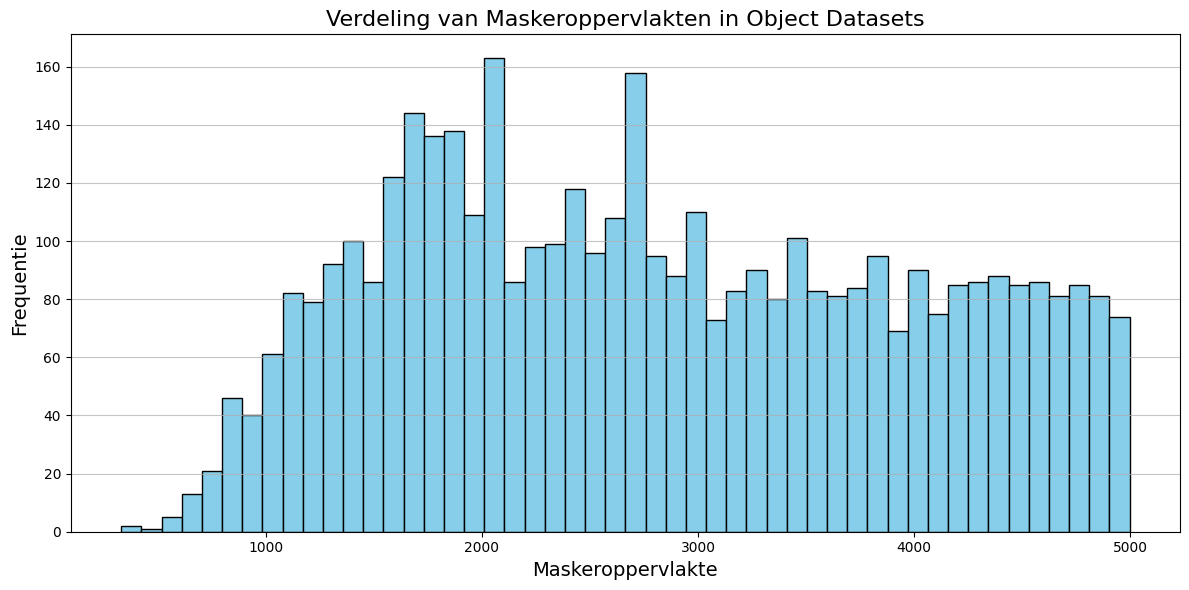

In [95]:
OBJECT_DATASETS_PATH = Path("data/object_datasets")
object_datasets = OBJECT_DATASETS_PATH.glob("*.csv")

mask_sizes = []

for dataset in object_datasets:
    df = pd.read_csv(dataset)
    for _, row in df.iterrows():
        if pd.notna(row["mask_area"]):
            mask_sizes.append(row["mask_area"])

mask_sizes_below_5000 = [size for size in mask_sizes if size < 5000]

mask_sizes_below_1000 = [size for size in mask_sizes if size < 1000]
print(f"Aantal maskers met oppervlakte < 1000: {len(mask_sizes_below_1000)}")
percentage_below_1000 = (len(mask_sizes_below_1000) / len(mask_sizes)) * 100
print(f"Percentage van maskers met oppervlakte < 1000: {percentage_below_1000:.2f}%")

# plot a histogram of the mask sizes
plt.figure(figsize=(12, 6))
plt.hist(mask_sizes_below_5000, bins=50, color='skyblue', edgecolor='black')
plt.title("Verdeling van Maskeroppervlakten in Object Datasets", fontsize=16)
plt.xlabel("Maskeroppervlakte", fontsize=14)
plt.ylabel("Frequentie", fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

Number of false negatives: 1857
True Class ID: 5.0 (stethoscoop) with 130 false negatives


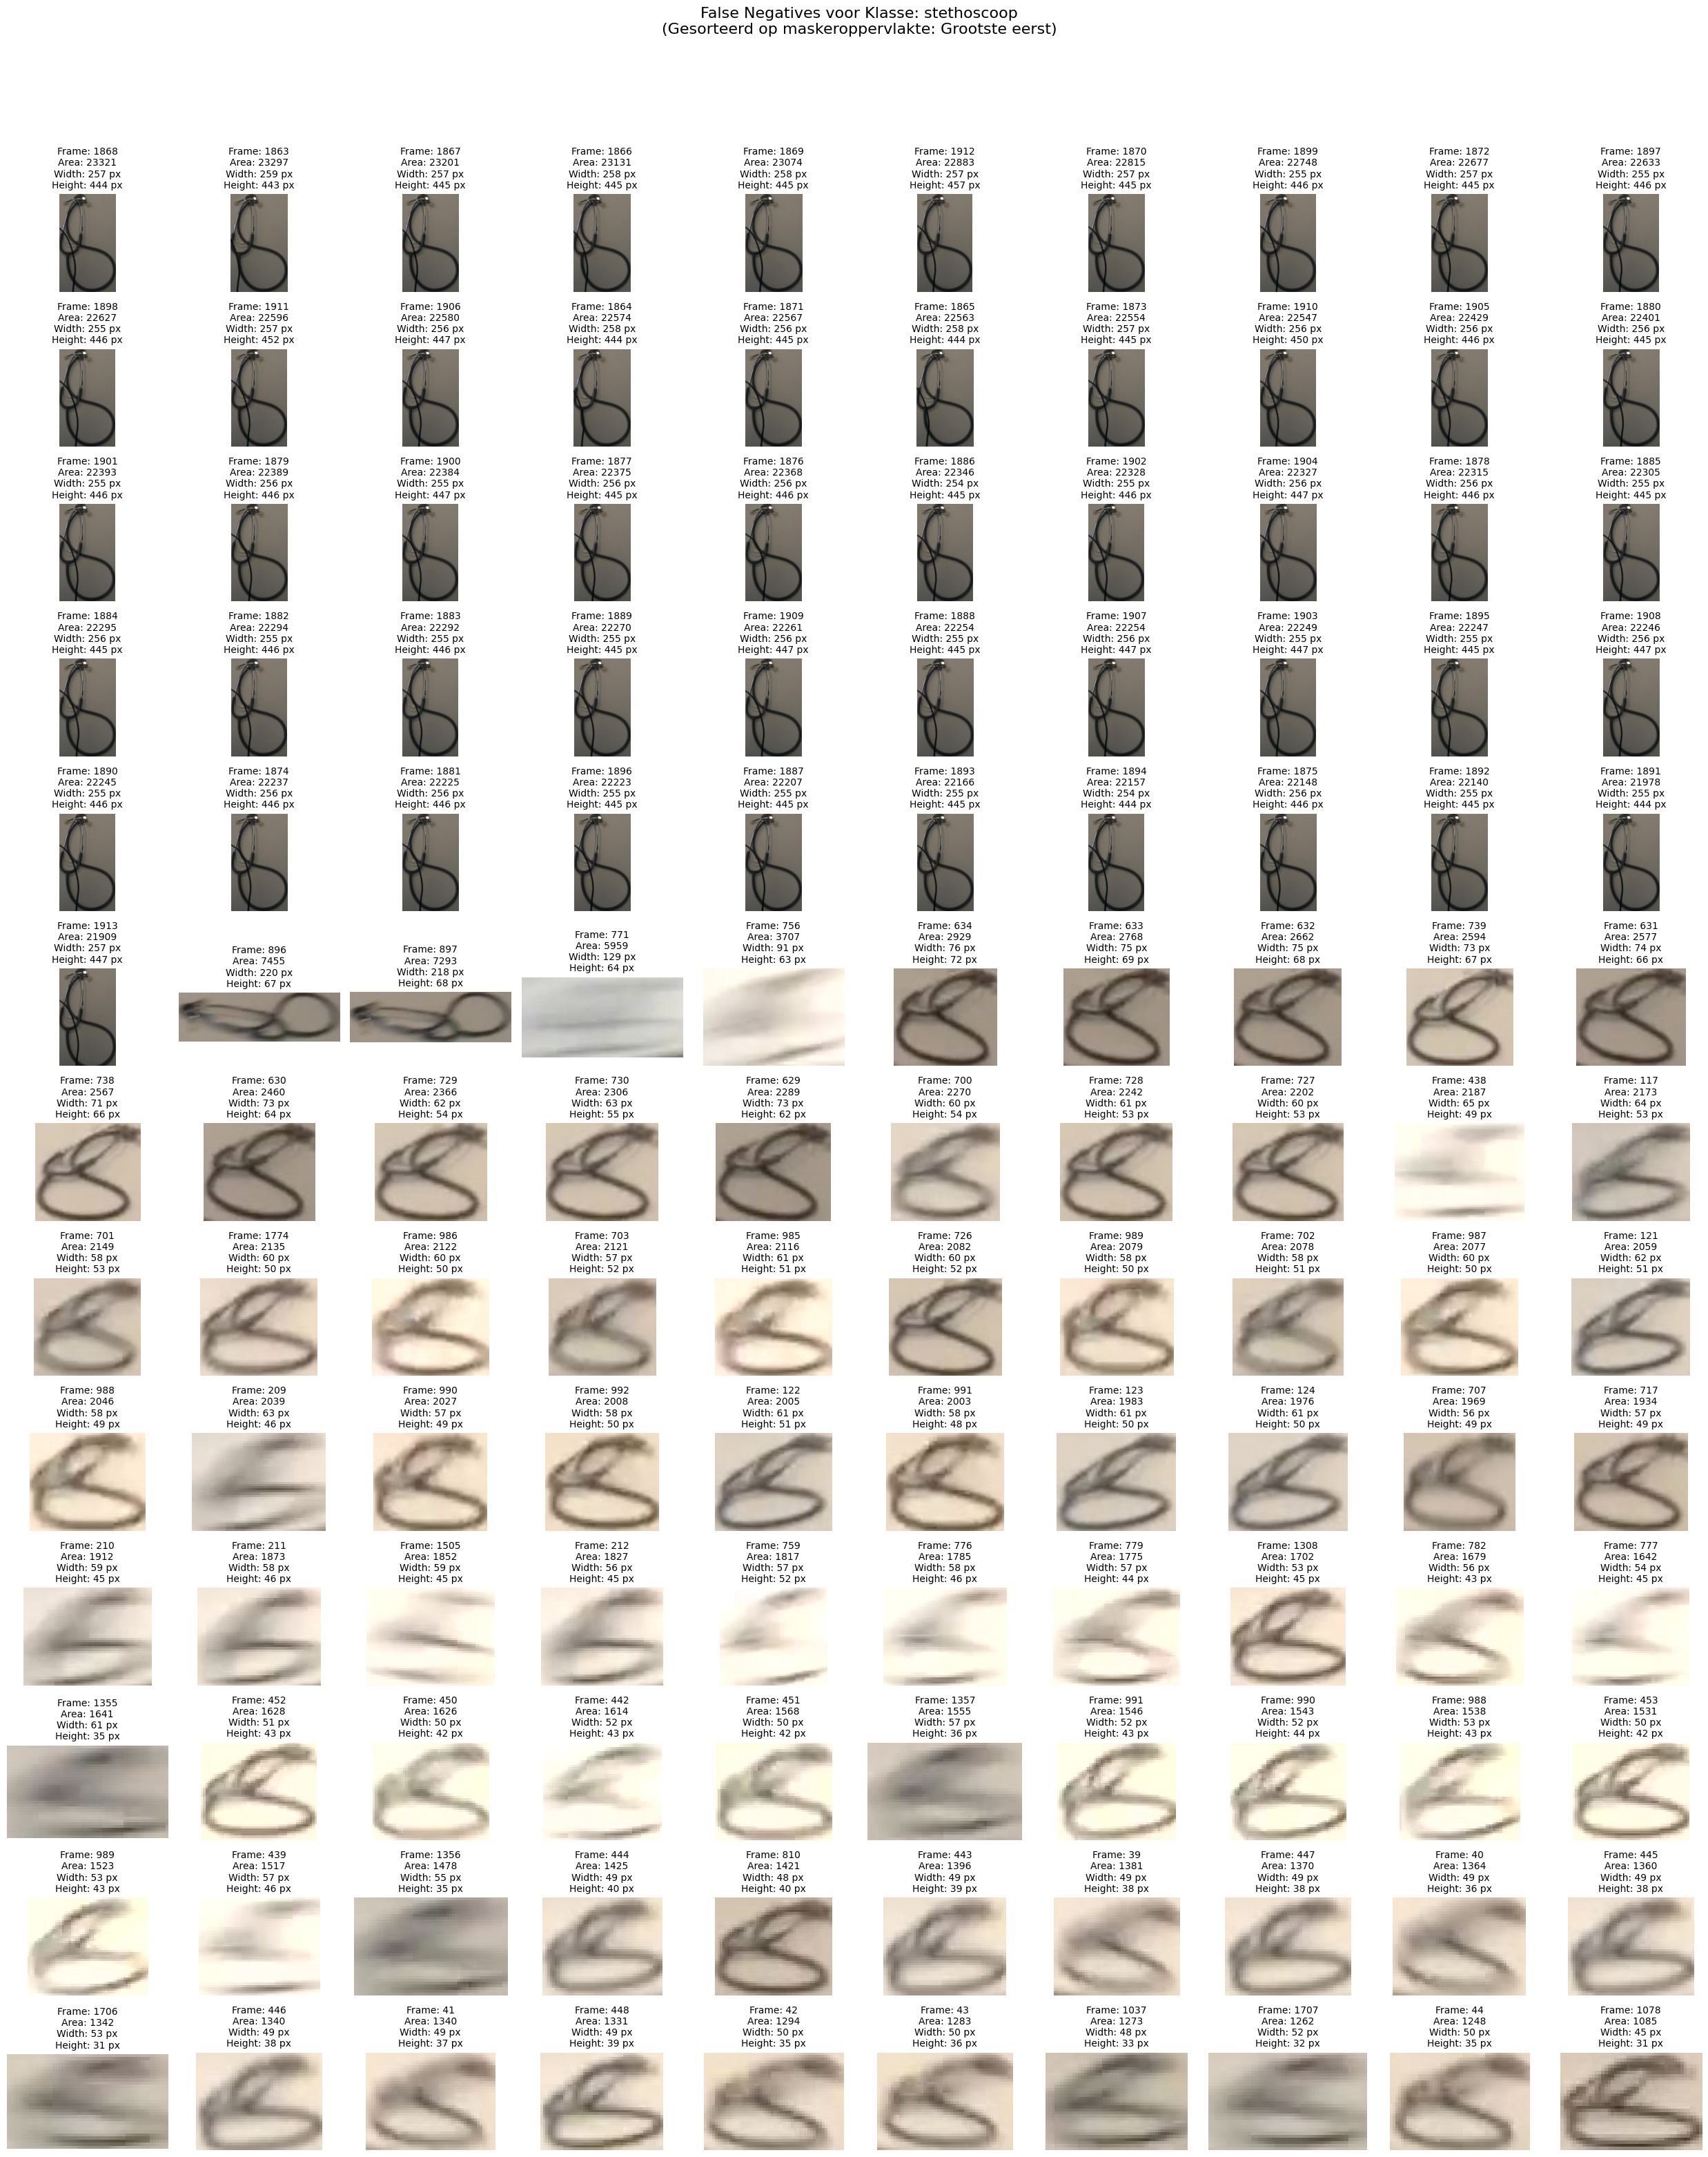

In [123]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# --- Vooronderstellingen ---
# evaluation_df, CLASS_ID_TO_NAME, RECORDING_FRAMES_PATH zijn gedefinieerd
# best_grid_search_result is gedefinieerd en bevat "full_evaluation_df"
# --- Einde vooronderstellingen ---

evaluation_df = best_grid_search_result["full_evaluation_df"]
fns_df = evaluation_df[evaluation_df["label"] == "FN"] # Verander naar FN

print(f"Number of false negatives: {len(fns_df)}")

selected_class_ids = [
    # NAME_TO_CLASS_ID["iced tea"],
    # NAME_TO_CLASS_ID["bol wol"],
    # NAME_TO_CLASS_ID["keukenmes"],
    # NAME_TO_CLASS_ID["bril"],
    # NAME_TO_CLASS_ID["monitor"],
    NAME_TO_CLASS_ID["stethoscoop"],
]

# Group false negatives by TRUE class
# Bij FN's is de 'true_class_id' de klasse die gemist is.
# De 'predicted_class_id' is meestal NaN of een achtergrondklasse voor FNs, dus minder relevant voor groepering hier.
for class_id, group in fns_df.groupby("true_class_id"): # Verander naar true_class_id
    class_name = CLASS_ID_TO_NAME.get(class_id, f"Unknown ID {class_id}")

    if class_id not in selected_class_ids:
        continue
    print(f"True Class ID: {class_id} ({class_name}) with {len(group)} false negatives")

    # Lijsten om de data per klasse op te slaan
    rois_data = [] # Sla hier tuples op van (roi_image, frame_idx, recording_id, mask_area)

    for idx, row in group.iterrows():
        recording_id = row["recording_id"]
        frame_idx = row["frame_idx"]
        mask_area = row.get("mask_area", 0) # Gebruik .get() voor het geval de kolom niet altijd bestaat, default naar 0

        # Coördinaten voor FNs zijn meestal van de ground truth bounding box
        # Zorg ervoor dat x1, y1, x2, y2 niet NaN zijn
        if pd.isna(row["x1"]) or pd.isna(row["y1"]) or pd.isna(row["x2"]) or pd.isna(row["y2"]):
            print(f"Skipping FN with NaN GT coordinates: Rec {recording_id}, Frame {frame_idx}")
            continue
        x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])

        frame_path = RECORDING_FRAMES_PATH / str(recording_id) / f"{int(frame_idx):05d}.jpg"

        try:
            image = cv2.imread(str(frame_path))
            if image is None:
                print(f"Warning: Could not read image {frame_path} for FN.")
                continue
        except Exception as e:
            print(f"Error reading image {frame_path} for FN: {e}")
            continue
        
        # Controleer of de ROI coördinaten geldig zijn binnen de afbeeldingsgrenzen
        img_h, img_w = image.shape[:2]
        if not (0 <= y1 < y2 <= img_h and 0 <= x1 < x2 <= img_w):
            print(f"Skipping FN with invalid ROI coordinates: Rec {recording_id}, Frame {frame_idx}, Box [{x1},{y1},{x2},{y2}] for image shape {(img_h, img_w)}")
            continue

        roi = image[y1:y2, x1:x2]
        if roi.size == 0:
            print(f"Skipping FN with empty ROI: Rec {recording_id}, Frame {frame_idx}, Box [{x1},{y1},{x2},{y2}]")
            continue

        rois_data.append({
            "roi_img": roi,
            "frame_idx": frame_idx,
            "recording_id": recording_id,
            "mask_area": mask_area,
            "width": x2 - x1, # Voeg breedte toe voor extra context
            "height": y2 - y1  # Voeg hoogte toe voor extra context
        })

    if not rois_data:
        print(f"No valid ROIs to display for FNs of class {class_name}")
        # Maak toch een lege plot om de structuur te behouden als je dat wilt, of continue.
        plt.figure(figsize=(5,2)) 
        plt.suptitle(f"No False Negatives for Class: {class_name}", fontsize=14)
        plt.axis('off')
        plt.show()
        continue

    # Sorteer ROIs op basis van mask_area (kleinste eerst, of grootste eerst met reverse=True)
    rois_data_sorted = sorted(rois_data, key=lambda x: x["mask_area"], reverse=True) # Grootste area eerst

    n = len(rois_data_sorted)
    max_cols = 10 # Maximaal aantal crops per rij
    n_cols = min(max_cols, n)
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5 * n_cols, 2.5 * n_rows), squeeze=False)
    axes = axes.flatten()

    for i, data_item in enumerate(rois_data_sorted):
        ax = axes[i]
        ax.imshow(cv2.cvtColor(data_item["roi_img"], cv2.COLOR_BGR2RGB))
        ax.axis("off")
        # Titel zonder object ID, maar met mask area voor context
        title_parts = [f"Frame: {int(data_item['frame_idx'])}"]
        if pd.notna(data_item["mask_area"]) and data_item["mask_area"] > 0 : # Toon area als het zinvol is
            title_parts.append(f"Area: {int(data_item['mask_area'])}")
            title_parts.append(f"Width: {data_item['width']} px")
            title_parts.append(f"Height: {data_item['height']} px")
        ax.set_title("\n".join(title_parts), fontsize=10)


    # Zet resterende, ongebruikte subplots uit
    for j in range(n, len(axes)): # Start vanaf n (aantal geplotte items)
        axes[j].axis("off")

    plt.suptitle(f"False Negatives voor Klasse: {class_name}\n(Gesorteerd op maskeroppervlakte: Grootste eerst)", fontsize=16)
    plt.tight_layout(rect=[0, 0.02, 1, 0.94]) # Pas rect aan voor suptitle
    plt.show()

# Final Metrics

In [105]:
best_result = get_best_grid_search_result(
    grid_search_results=grid_search_results, metric="micro_f1"
)

with Session(engine) as session:
    class_id_to_color = get_class_id_to_color(Session(bind=engine))


In [113]:
      
import pandas as pd
import numpy as np

def test_gt_track_consistency(df_with_gt_tracks: pd.DataFrame):
    print("Starten van compacte consistentietest voor gt_track_id...")
    
    tracks_df = df_with_gt_tracks[
        df_with_gt_tracks['gt_track_id'].notna() &
        (df_with_gt_tracks['true_class_id'].notna() & (df_with_gt_tracks['true_class_id'] >= 0))
    ].copy()

    if tracks_df.empty:
        print("Geen gt_tracks gevonden om te testen. Test overgeslagen.")
        return

    # Controleer per track:
    # 1. Unieke recording_id
    # 2. Unieke true_class_id
    # 3. true_class_id >= 0 (eigenlijk al gefilterd, maar als sanity check)
    # 4. Opeenvolgende frames (verschil tussen min en max frame + 1 == aantal unieke frames)
    
    # Aggregeer per gt_track_id
    agg_funcs = {
        'recording_id': 'nunique',    # Aantal unieke recording_ids
        'true_class_id': ['nunique', 'min'], # Aantal unieke true_class_ids en de min waarde
        'frame_idx': ['min', 'max', 'nunique'] # Min, max, en aantal unieke frames
    }
    track_summary = tracks_df.groupby('gt_track_id').agg(agg_funcs)

    # Hernoem kolommen voor makkelijkere toegang (multi-index na agg)
    track_summary.columns = ['_'.join(col).strip() for col in track_summary.columns.values]
    
    # Test 1: recording_id moet 1 unieke waarde hebben per track
    inconsistent_recordings = track_summary[track_summary['recording_id_nunique'] != 1]
    assert inconsistent_recordings.empty, \
        f"Inconsistentie: Tracks met meerdere recording_ids:\n{inconsistent_recordings.index.tolist()}"

    # Test 2: true_class_id moet 1 unieke waarde hebben per track
    inconsistent_true_classes = track_summary[track_summary['true_class_id_nunique'] != 1]
    assert inconsistent_true_classes.empty, \
        f"Inconsistentie: Tracks met meerdere true_class_ids:\n{inconsistent_true_classes.index.tolist()}"

    # Test 2b: true_class_id_min moet >= 0 zijn
    invalid_true_class_min = track_summary[track_summary['true_class_id_min'] < 0]
    assert invalid_true_class_min.empty, \
        f"Inconsistentie: Tracks met true_class_id < 0:\n{invalid_true_class_min.index.tolist()}"

    # Test 3: Opeenvolgende frames
    # Voor een aaneengesloten reeks frames, moet: max_frame - min_frame + 1 == nunique_frames
    # Dit vangt gaten en incorrecte sortering (als nunique kleiner is dan verwacht)
    track_summary['expected_nunique_frames'] = track_summary['frame_idx_max'] - track_summary['frame_idx_min'] + 1
    inconsistent_frames = track_summary[track_summary['frame_idx_nunique'] != track_summary['expected_nunique_frames']]
    
    # Voordat we de assert doen, printen we de problematische tracks voor makkelijker debuggen
    if not inconsistent_frames.empty:
        print("FOUT: Inconsistentie in frame opeenvolging voor de volgende gt_track_ids:")
        for track_id, row in inconsistent_frames.iterrows():
            original_frames = tracks_df[tracks_df['gt_track_id'] == track_id]['frame_idx'].sort_values().tolist()
            print(f"  Track ID: {track_id}, Min: {row['frame_idx_min']}, Max: {row['frame_idx_max']}, "
                  f"NUnique: {row['frame_idx_nunique']}, Expected NUnique: {row['expected_nunique_frames']}, "
                  f"Originele Frames: {original_frames}")
        assert inconsistent_frames.empty, "Frame opeenvolging is niet consistent voor sommige tracks."
    
    print("Consistentietest voor gt_track_id succesvol afgerond. Alle geteste tracks lijken consistent.")

def assign_gt_track_ids(eval_df: pd.DataFrame) -> pd.DataFrame:
    """
    Identificeert grondwaarheid-tracks (opeenvolgende frames van dezelfde true_class_id
    binnen een recording) en kent een unieke 'gt_track_id' toe aan elke track.

    Een track wordt gedefinieerd als elke opeenvolging van GT objecten 
    van dezelfde klasse (true_class_id, met een id groter of gelijk aan 0). 
    Opeenvolging = frame per frame aan mekaar plakken.

    Args:
        eval_df (pd.DataFrame): De evaluatie DataFrame met kolommen zoals
                                'recording_id', 'frame_idx', 'true_class_id'.

    Returns:
        pd.DataFrame: De input DataFrame met een extra kolom 'gt_track_id'.
    """
    
    df = eval_df.copy()

    df_gt_present = df[df['true_class_id'].notna() & (df['true_class_id'] >= 1)].copy()
    
    # Sorteer voor correcte track-identificatie
    df_gt_present.sort_values(by=['recording_id', 'true_class_id', 'frame_idx'], inplace=True)

    # Identificeer wisselingen die een nieuwe track starten
    # Een nieuwe track start als:
    # 1. recording_id verandert
    # 2. true_class_id verandert (binnen dezelfde recording)
    # 3. Er een gat is in frame_idx (>1) voor dezelfde recording en true_class_id
    
    # Shift de kolommen om te vergelijken met de vorige rij
    df_gt_present['prev_recording_id'] = df_gt_present['recording_id'].shift(1)
    df_gt_present['prev_true_class_id'] = df_gt_present['true_class_id'].shift(1)
    df_gt_present['prev_frame_idx'] = df_gt_present['frame_idx'].shift(1)

    # Bepaal of een rij de start van een nieuwe track is
    # pd.Series.ne is "not equal"
    # pd.Series.gt is "greater than"
    is_new_track = (
        (df_gt_present['recording_id'] != df_gt_present['prev_recording_id']) |
        (df_gt_present['true_class_id'] != df_gt_present['prev_true_class_id']) |
        (df_gt_present['frame_idx'] > df_gt_present['prev_frame_idx'] + 1)
    )
    
    # De allereerste rij is altijd de start van een nieuwe track
    is_new_track.iloc[0] = True 
    
    # Cumulatieve som van 'is_new_track' geeft unieke track IDs
    # Deze IDs zijn numeriek en beginnen vanaf 1.
    df_gt_present['gt_track_id_temp'] = is_new_track.cumsum()

    # Voeg de tijdelijke track ID kolom samen met de originele DataFrame
    # We gebruiken een left merge om de gt_track_id_temp alleen aan de relevante rijen toe te voegen
    # en dan de gt_track_id in de volledige 'df' te vullen.
    # De index van df_gt_present is behouden, dus we kunnen direct mergen.
    df = df.merge(df_gt_present[['gt_track_id_temp']], left_index=True, right_index=True, how='left')
    
    # Hernoem naar de gewenste kolomnaam 'gt_track_id'
    df.rename(columns={'gt_track_id_temp': 'gt_track_id'}, inplace=True)
    
    # Converteer naar nullable integer type als er NaNs kunnen zijn (voor rijen zonder GT)
    df['gt_track_id'] = df['gt_track_id'].astype('Int64')

    # Verwijder de tijdelijke 'prev_' kolommen als ze niet meer nodig zijn
    # (df_gt_present was een kopie, dus die kolommen zijn niet in de originele df)

    return df


Starten van compacte consistentietest voor gt_track_id...
Consistentietest voor gt_track_id succesvol afgerond. Alle geteste tracks lijken consistent.

Gemiddelde Temporele Coverage Ratio per Klasse:
class_name
naaldcontainer     0.858185
infuus             0.755742
nuchter            0.673907
bol wol            0.626667
fotokader          0.583986
bril               0.490735
rollator           0.466423
stethoscoop        0.450686
iced tea           0.426924
monitor            0.326298
keukenmes          0.222444
spuit              0.205590
snoep              0.186826
ampulevloeistof    0.120048
Name: temporal_coverage_ratio, dtype: float64


/tmp/ipykernel_18249/2619489826.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_coverage_per_class.index, y=avg_coverage_per_class.values, palette=class_name_to_color)


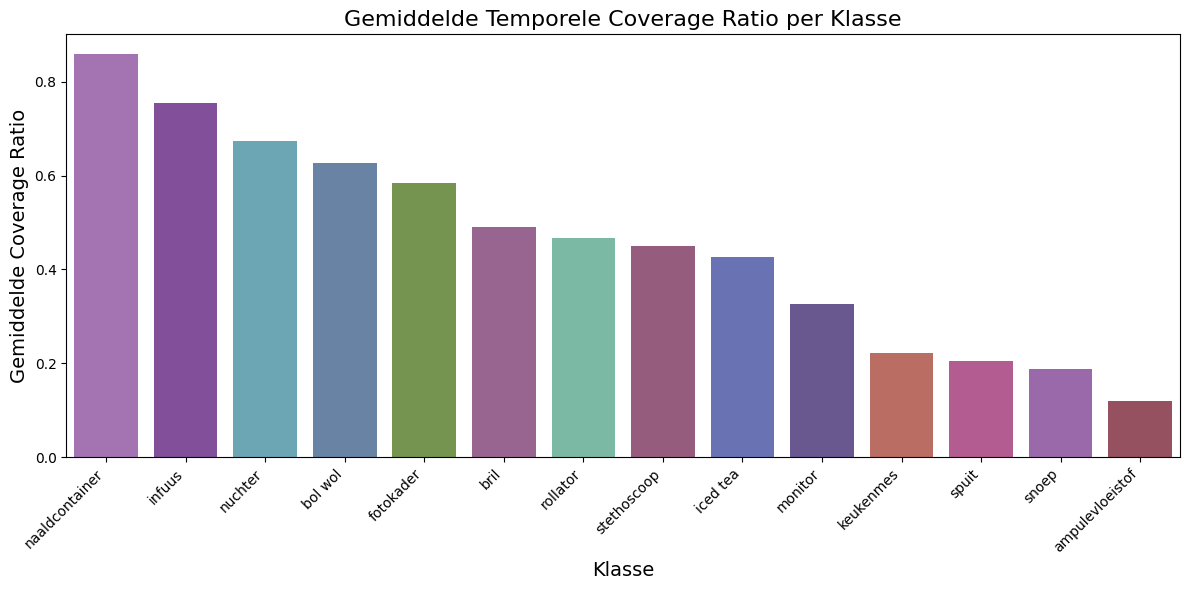

/tmp/ipykernel_18249/2619489826.py:196: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class_name', y='temporal_coverage_ratio',



Gemiddelde Temporele Coverage Ratio per Klasse (voor sortering plot):
class_name
naaldcontainer     0.858185
infuus             0.755742
nuchter            0.673907
bol wol            0.626667
fotokader          0.583986
bril               0.490735
rollator           0.466423
stethoscoop        0.450686
iced tea           0.426924
monitor            0.326298
keukenmes          0.222444
spuit              0.205590
snoep              0.186826
ampulevloeistof    0.120048
Name: temporal_coverage_ratio, dtype: float64

Mediaan Temporele Coverage Ratio per Klasse:
class_name
naaldcontainer     1.000000
infuus             1.000000
nuchter            0.923077
bol wol            0.960000
fotokader          0.785714
bril               0.555556
rollator           0.472222
stethoscoop        0.000000
iced tea           0.000000
monitor            0.000000
keukenmes          0.000000
spuit              0.000000
snoep              0.000000
ampulevloeistof    0.000000
Name: temporal_coverage_ratio, 

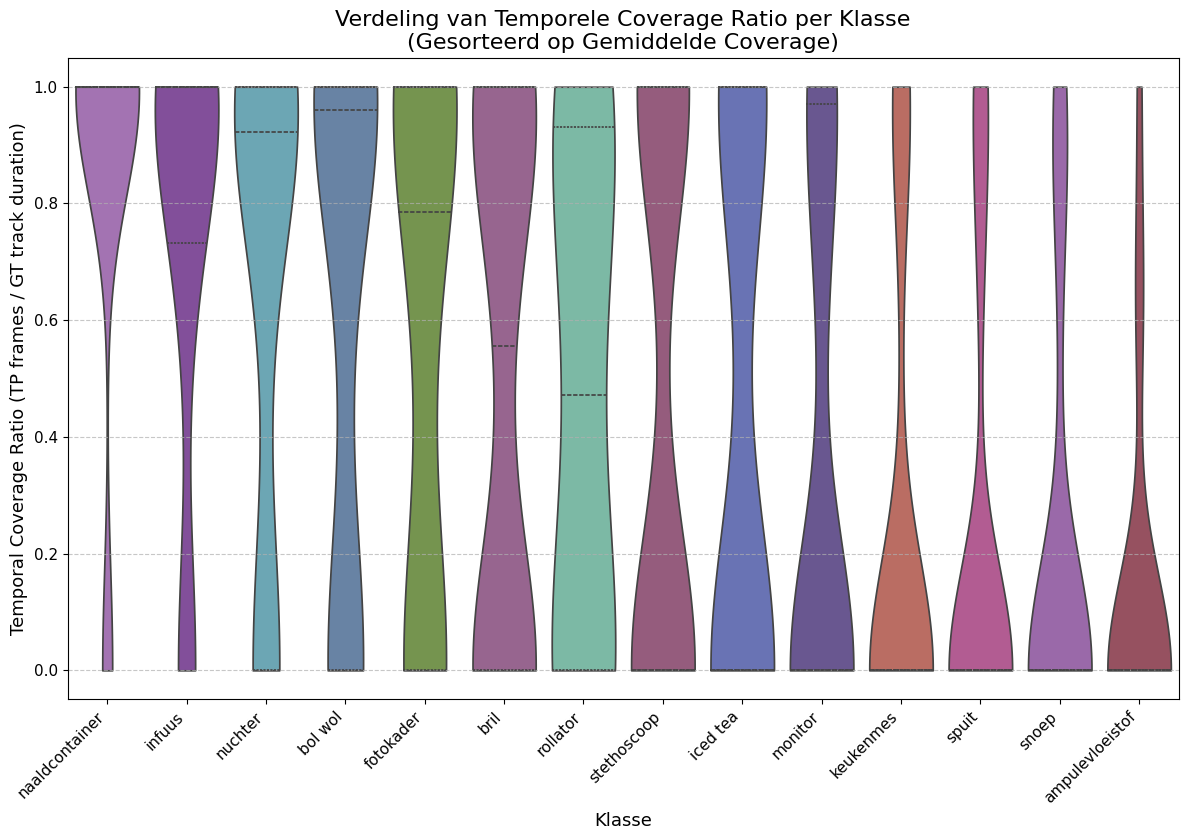

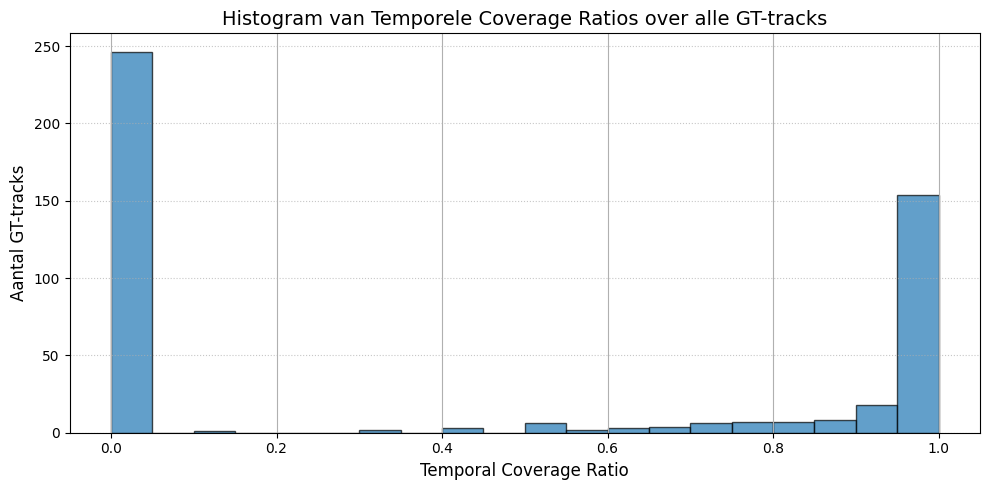

In [122]:
      
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Vooronderstellingen ---
# evaluation_df_with_gt_tracks: DataFrame geretourneerd door assign_gt_track_ids
# CLASS_ID_TO_NAME: dictionary die class IDs naar namen mapt
# --- Einde vooronderstellingen ---

def calculate_temporal_track_metrics(eval_df_with_gt_tracks: pd.DataFrame) -> pd.DataFrame:
    """
    Berekent temporele metrieken per grondwaarheid-track, zoals 
    GT-duur, aantal TP-frames binnen de track, en de coverage ratio.

    Args:
        eval_df_with_gt_tracks (pd.DataFrame): DataFrame met 'gt_track_id', 
                                               'true_class_id', 'label', 'frame_idx'.

    Returns:
        pd.DataFrame: DataFrame met metrieken per gt_track_id.
                      Kolommen: 'gt_track_id', 'true_class_id', 'class_name', 
                                'gt_duration_frames', 'tp_frames_in_track', 
                                'temporal_coverage_ratio', 'fragmentation_count'.
    """
    
    # Filter op rijen die daadwerkelijk een gt_track_id hebben (dus valide GT-tracks)
    # en waar true_class_id ook geldig is (nodig voor groeperen per klasse later)
    valid_tracks_df = eval_df_with_gt_tracks[
        eval_df_with_gt_tracks['gt_track_id'].notna() &
        eval_df_with_gt_tracks['true_class_id'].notna() &
        (eval_df_with_gt_tracks['true_class_id'] >= 0) # Alleen "echte" klassen
    ].copy()

    if valid_tracks_df.empty:
        print("Geen valide GT-tracks gevonden om metrieken voor te berekenen.")
        return pd.DataFrame(columns=[
            'gt_track_id', 'true_class_id', 'class_name', 
            'gt_duration_frames', 'tp_frames_in_track', 
            'temporal_coverage_ratio', 'fragmentation_count'
        ])

    track_metrics_list = []

    for gt_track_id, group in valid_tracks_df.groupby('gt_track_id'):
        # Sorteer frames binnen de track voor fragmentatieberekening
        group_sorted = group.sort_values('frame_idx')
        
        # Bepaal GT-duur
        # min/max frame_idx binnen deze gt_track_id groep
        # (deze groep bevat alle frames die tot deze gt_track_id behoren)
        min_frame = group_sorted['frame_idx'].min()
        max_frame = group_sorted['frame_idx'].max()
        gt_duration_frames = max_frame - min_frame + 1

        # Bepaal TP-frames binnen deze GT-track
        tp_frames = group_sorted[group_sorted['label'] == 'TP']['frame_idx'].unique()
        tp_frames_in_track = len(tp_frames)

        # Bereken Temporal Coverage Ratio
        if gt_duration_frames > 0:
            temporal_coverage_ratio = tp_frames_in_track / gt_duration_frames
        else:
            # Dit zou niet mogen gebeuren als gt_track_id correct is (track van 1 frame heeft duur 1)
            temporal_coverage_ratio = 0.0 if tp_frames_in_track == 0 else 1.0 

        # Bereken Fragmentation Count (aantal aaneengesloten TP-blokken)
        fragmentation_count = 0
        if tp_frames_in_track > 0:
            # Sorteer de TP frames (zou al moeten zijn door group_sorted, maar voor zekerheid)
            sorted_tp_frames = np.sort(tp_frames)
            # Verschillen tussen opeenvolgende TP frames
            diffs = np.diff(sorted_tp_frames)
            # Een fragmentatie (nieuw blok) start waar het verschil > 1 is
            fragmentation_count = 1 + np.sum(diffs > 1)
        
        true_class_id = group_sorted['true_class_id'].iloc[0] # Alle rijen in groep hebben dezelfde true_class_id
        class_name = CLASS_ID_TO_NAME.get(true_class_id, f"ID {true_class_id}")

        track_metrics_list.append({
            'gt_track_id': gt_track_id,
            'true_class_id': true_class_id,
            'class_name': class_name,
            'gt_duration_frames': gt_duration_frames,
            'tp_frames_in_track': tp_frames_in_track,
            'temporal_coverage_ratio': temporal_coverage_ratio,
            'fragmentation_count': fragmentation_count if tp_frames_in_track > 0 else 0 # Geen fragmenten als geen TPs
        })
        
    return pd.DataFrame(track_metrics_list)

# 1. Genereer eerst de gt_track_ids (functie uit vorig antwoord)
# Voorbeeld van hoe je de functie zou kunnen aanroepen:]
evaluation_df = best_result["full_evaluation_df"]
evaluation_df_with_gt_tracks = assign_gt_track_ids(evaluation_df)
test_gt_track_consistency(evaluation_df_with_gt_tracks)    

# 2. Bereken de temporele metrieken per track
df_temporal_metrics_per_track = calculate_temporal_track_metrics(evaluation_df_with_gt_tracks)

# 3. Analyseer de resultaten per klasse
if not df_temporal_metrics_per_track.empty:
    # Gemiddelde coverage ratio per klasse
    avg_coverage_per_class = df_temporal_metrics_per_track.groupby('class_name')['temporal_coverage_ratio'].mean().sort_values(ascending=False)
    print("\nGemiddelde Temporele Coverage Ratio per Klasse:")
    print(avg_coverage_per_class)

    # toon bar chart van de gemiddelde coverage ratio per klasse, gebruik de kleur class_id_to_color
    class_name_to_color = {}
    for class_id, color in class_id_to_color.items():
        class_name = CLASS_ID_TO_NAME.get(class_id, f"ID {class_id}")
        class_name_to_color[class_name] = color

    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_coverage_per_class.index, y=avg_coverage_per_class.values, palette=class_name_to_color)
    plt.xticks(rotation=45, ha='right')
    plt.title("Gemiddelde Temporele Coverage Ratio per Klasse", fontsize=16)
    plt.xlabel("Klasse", fontsize=14)
    plt.ylabel("Gemiddelde Coverage Ratio", fontsize=14)
    plt.tight_layout()
    plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ... (de functies assign_gt_track_ids en calculate_temporal_track_metrics blijven hetzelfde) ...
# ... (ook de code om df_temporal_metrics_per_track en median_coverage_per_class te berekenen) ...

# --- VOORONDERSTELLINGEN VOOR KLEUREN ---
# CLASS_ID_TO_NAME = {0: "Appel", 1: "Banaan", ...}
# class_id_to_color = {0: "#FF0000", 1: "#00FF00", ...} # Voorbeeld met hex kleuren

# Maak een inverse mapping van naam naar ID voor gemakkelijke lookup
# Zorg ervoor dat CLASS_ID_TO_NAME alle relevante namen bevat uit je data
if 'CLASS_ID_TO_NAME' in locals() and CLASS_ID_TO_NAME: # Check of het bestaat en niet leeg is
    NAME_TO_CLASS_ID = {v: k for k, v in CLASS_ID_TO_NAME.items()}
else:
    print("Waarschuwing: CLASS_ID_TO_NAME is niet gedefinieerd of leeg. Kleuren worden niet per klasse toegepast.")
    NAME_TO_CLASS_ID = {}
    class_id_to_color = {} # Voorkom errors verderop

# --- Visualisatie met VIOLIN PLOTS en AANGEPASTE KLEUREN ---
if not df_temporal_metrics_per_track.empty:
    # --- AANGEPAST: Sorteer op GEMIDDELDE coverage ratio ---
    avg_coverage_per_class = df_temporal_metrics_per_track.groupby('class_name')['temporal_coverage_ratio'].mean().sort_values(ascending=False)
    sorted_classes_for_plot = avg_coverage_per_class.index # Dit zijn klassenNAMEN, gesorteerd op gemiddelde
    # --- EINDE AANPASSING ---

    print("\nGemiddelde Temporele Coverage Ratio per Klasse (voor sortering plot):")
    print(avg_coverage_per_class)
    
    # Mediaan en fragmentatie kunnen nog steeds interessant zijn om apart te printen
    median_coverage_per_class = df_temporal_metrics_per_track.groupby('class_name')['temporal_coverage_ratio'].median()
    print("\nMediaan Temporele Coverage Ratio per Klasse:")
    print(median_coverage_per_class.loc[sorted_classes_for_plot]) # Toon in dezelfde volgorde als de plot

    avg_fragmentation_per_class = df_temporal_metrics_per_track[
        df_temporal_metrics_per_track['tp_frames_in_track'] > 0
    ].groupby('class_name')['fragmentation_count'].mean()
    print("\nGemiddelde Fragmentatie Count per Klasse (voor tracks met TPs):")
    if not avg_fragmentation_per_class.empty:
        print(avg_fragmentation_per_class.loc[avg_fragmentation_per_class.index.isin(sorted_classes_for_plot)].reindex(sorted_classes_for_plot).dropna())
    else:
        print("Geen data voor fragmentatie.")


    plt.figure(figsize=(max(12, len(sorted_classes_for_plot) * 0.8), 8.5))

    plot_palette = []
    valid_sorted_classes_for_color_lookup = []
    for class_name_in_plot in sorted_classes_for_plot:
        class_id = NAME_TO_CLASS_ID.get(class_name_in_plot)
        if class_id is not None:
            color = class_id_to_color.get(class_id, "#808080") 
            plot_palette.append(color)
            valid_sorted_classes_for_color_lookup.append(class_name_in_plot)
        else:
            print(f"Waarschuwing: Kon geen class_id vinden voor class_name '{class_name_in_plot}'. Gebruik fallback kleur.")
            plot_palette.append("#808080")
            valid_sorted_classes_for_color_lookup.append(class_name_in_plot)
            
    data_for_plot = df_temporal_metrics_per_track[df_temporal_metrics_per_track['class_name'].isin(valid_sorted_classes_for_color_lookup)]

    if not plot_palette or data_for_plot.empty:
        print("Kon geen palet genereren of geen data om te plotten na kleur filtering. Standaard palet wordt gebruikt of plot wordt overgeslagen.")
        if data_for_plot.empty:
             print("Geen data om violin plot te maken.")
        elif valid_sorted_classes_for_color_lookup : # Alleen als er klassen zijn om te kleuren
             plot_palette = sns.color_palette("viridis", n_colors=len(valid_sorted_classes_for_color_lookup))
        else:
             plot_palette = None # Geen palet als er geen klassen zijn
    
    if not data_for_plot.empty and plot_palette:
        sns.violinplot(x='class_name', y='temporal_coverage_ratio', 
                       data=data_for_plot, 
                       order=valid_sorted_classes_for_color_lookup,
                       palette=plot_palette,
                       cut=0,
                       inner="quartile"
                      )
        
        plt.xticks(rotation=45, ha="right", fontsize=11)
        plt.yticks(fontsize=11)
        plt.title("Verdeling van Temporele Coverage Ratio per Klasse\n(Gesorteerd op Gemiddelde Coverage)", fontsize=16) # Titel aangepast
        plt.ylabel("Temporal Coverage Ratio (TP frames / GT track duration)", fontsize=13)
        plt.xlabel("Klasse", fontsize=13)
        plt.ylim(-0.05, 1.05)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("Violin plot overgeslagen wegens ontbrekende data of palet.")

    if not df_temporal_metrics_per_track.empty:
        plt.figure(figsize=(10, 5))
        df_temporal_metrics_per_track['temporal_coverage_ratio'].hist(bins=20, edgecolor='black', alpha=0.7)
        plt.title("Histogram van Temporele Coverage Ratios over alle GT-tracks", fontsize=14)
        plt.xlabel("Temporal Coverage Ratio", fontsize=12)
        plt.ylabel("Aantal GT-tracks", fontsize=12)
        plt.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.show()
else:
    print("Geen track metrieken berekend om te analyseren.")

# Render Final Predictions

In [ ]:
def draw_video_frames(
    session: Session,
    frames: list[Path],
    frame_to_gaze_position: dict[int, tuple[int, int]],
    predictions_df: pd.DataFrame,
    draw_unknowns: bool = False,
):
    # Iterate over frames and draw the annotations on them if they exist
    for frame in tqdm(frames, desc="Drawing annotations on frames"):
        frame_idx = int(frame.stem)
        frame_img = cv2.imread(str(frame))

        # iterate through the predictions with the same frame index
        frame_predictions = predictions_df[predictions_df["frame_idx"] == frame_idx]
        for _, row in frame_predictions.iterrows():
            class_id = int(row["predicted_class_id"])
            class_name = CLASS_ID_TO_NAME[class_id]
            box = (int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"]))

            try:
                simroom_class = simrooms_service.get_simroom_class(session, class_id)
                color = simroom_class.color
            except:
                if draw_unknowns:
                    color = "#FF0000"
                else:
                    continue

            frame_img = image_utils.draw_labeled_box(frame_img, box, class_name, color)

        # Draw the gaze point on the frame
        if frame_to_gaze_position.get(frame_idx) is not None:
            gx, gy = frame_to_gaze_position[frame_idx]

            cv2.circle(
                frame_img,
                (int(gx), int(gy)),
                radius=VIEWED_RADIUS,
                color=(0, 0, 255),
                thickness=2,
            )

        # Save the modified image back to its original location
        cv2.imwrite(str(frame), frame_img)

In [ ]:
for model in models:
    model_name = model.stem
    model = YOLO(model)

    if FINAL_PREDICTION_VIDEOS_PATH.exists():
        shutil.rmtree(FINAL_PREDICTION_VIDEOS_PATH)
    FINAL_PREDICTION_VIDEOS_PATH.mkdir(parents=True, exist_ok=True)

    prediction_results = (OBJECT_DETECTION_PREDICTIONS_PATH / model_name).iterdir()
    for prediction_result_path in prediction_results:
        recording_id = prediction_result_path.stem
        predictions_df = pd.read_csv(prediction_result_path)

        video_path = RECORDINGS_PATH / f"{recording_id}.mp4"

        frames, tmp_frames_dir = simrooms_service.extract_tmp_frames(recording_id)
        tmp_frames_path = Path(tmp_frames_dir.name)

        frame_to_gaze_position = gaze_service.get_gaze_position_per_frame(
            recording_id, len(frames)
        )

        with Session(engine) as session:
            draw_video_frames(
                session=session,
                frames=frames,
                frame_to_gaze_position=frame_to_gaze_position,
                predictions_df=predictions_df,
            )

        print(f"Creating video for {recording_id}")
        video_result_path = FINAL_PREDICTION_VIDEOS_PATH / f"{recording_id}.mp4"
        cmd = f'ffmpeg -hwaccel cuda -y -pattern_type glob -framerate {TOBII_GLASSES_FPS} -i "{str(tmp_frames_path)!s}/*.jpg" -c:v libx264 -pix_fmt yuv420p "{str(video_result_path)}"'
        subprocess.run(cmd, shell=True)

Drawing annotations on frames: 100%|██████████| 1365/1365 [00:10<00:00, 127.80it/s]
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheo

Creating video for 32f02db7-adc0-4556-a2da-ed2ba60a58c9


Stream mapping:
  Stream #0:0 -> #0:0 (mjpeg (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0x55d7c25c7940] using SAR=1/1
[libx264 @ 0x55d7c25c7940] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2 AVX512
[libx264 @ 0x55d7c25c7940] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55d7c25c7940] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=24 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=24 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1

Creating video for 67b71a70-da64-467a-9fb6-91bc29265fd1


Stream mapping:
  Stream #0:0 -> #0:0 (mjpeg (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0x55d653650380] using SAR=1/1
[libx264 @ 0x55d653650380] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2 AVX512
[libx264 @ 0x55d653650380] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55d653650380] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=24 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=24 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1

Drawing annotations on frames: 100%|██████████| 1557/1557 [00:11<00:00, 132.72it/s]
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheo

Creating video for b8eeecc0-06b1-47f7-acb5-89aab3c1724d


Stream mapping:
  Stream #0:0 -> #0:0 (mjpeg (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0x56058b8b4b00] using SAR=1/1
[libx264 @ 0x56058b8b4b00] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2 AVX512
[libx264 @ 0x56058b8b4b00] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x56058b8b4b00] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=24 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=24 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1